In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../coral')
sys.path.append('../')

import utils_HCC, visium_codex_process
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random 
import scipy
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset,ConcatDataset
from scipy.stats import zscore

from sklearn.neighbors import KDTree,NearestNeighbors
from coral import coral_main, VisCoxDataset, utils, utils_exp, utils_simu
from scipy.spatial import cKDTree

import scanpy as sc
import anndata
import torch

import os

In [2]:
import matplotlib as mpl
# Set the font family to DejaVuSans or another font with full sentence support
mpl.rcParams['pdf.fonttype'] = 42  # Ensures text is stored as Type 3 font (OpenType)
mpl.rcParams['ps.fonttype'] = 42  # PostScript font type for compatibility


In [3]:
adata1 = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/data_0_preprossed.h5ad')
adata2 = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/data_1_preprossed.h5ad')
adata3 = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/data_2_preprossed.h5ad')
adata4 = sc.read_h5ad('/hpc/mydata/siyu.he/Siyu_projects/coral_storage/coral_results/hcc_results/data_3_preprossed.h5ad')


In [4]:
cell_type_label_mapping = {'Neutrophils': 0,
 'Macrophages': 1,
 'B cells': 2,
 'CD4 T cells': 3,
 'Stroma Uncharacterized': 4,
 'INFg+': 5,
 'Macrophages M2-like': 6,
 'Fibroblasts': 7,
 'Endothelial cells': 8,
 'Tumor Inos': 9,
 'Tumor': 10,
 'CD8 T cells': 11,
 'Dendritic cells': 12,
 'Unknown': 13}
reversed_mapping = {v: k for k, v in cell_type_label_mapping.items()}

select_gene = np.load('../../HCCproject3/select_gene.npy',allow_pickle=True)
pg_dist = utils_HCC.return_protein_to_gene()
select_gene = np.append(select_gene,[pg_dist[i] for i in pg_dist.keys()])
select_gene = np.unique(select_gene)

cell_type_marker = pd.read_csv('bc_signatures_version_1013.csv')



In [5]:
adata_all = sc.concat([adata1,adata2,adata3,adata4])
adata_all.obs['niche_classify_major'] = [i.split('_')[0] for i in adata_all.obs['niche_classify']]
adata_all_immune = adata_all[adata_all.obs['codex_type_label'].isin(['Tumor','Tumor Inos'])].copy()

adata_all_immune_scRNA = anndata.AnnData(adata_all_immune.obsm['generated_expr'])
adata_all_immune_scRNA.obs = adata_all_immune.obs
adata_all_immune_scRNA.obsm = adata_all_immune.obsm
adata_all_immune_scRNA.var_names = select_gene
adata_all_immune_scRNA.raw = adata_all_immune_scRNA

sc.pp.normalize_total(adata_all_immune_scRNA)
sc.pp.log1p(adata_all_immune_scRNA)
sc.tl.pca(adata_all_immune_scRNA)
sc.pp.neighbors(adata_all_immune_scRNA)
sc.tl.umap(adata_all_immune_scRNA)


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
adata_all_immune_scRNA

AnnData object with n_obs × n_vars = 34578 × 1076
    obs: 'leiden', 'sample', 'treatment', 'responder', 'niche_classify', 'codex_type_label', 'niche_classify_major'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'cell_types', 'codex_true', 'coral', 'generated_expr', 'spatial', 'v_values', 'visium_true', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

(-12.027347135543824,
 26.737358617782593,
 -13.454123163223267,
 24.720498704910277)

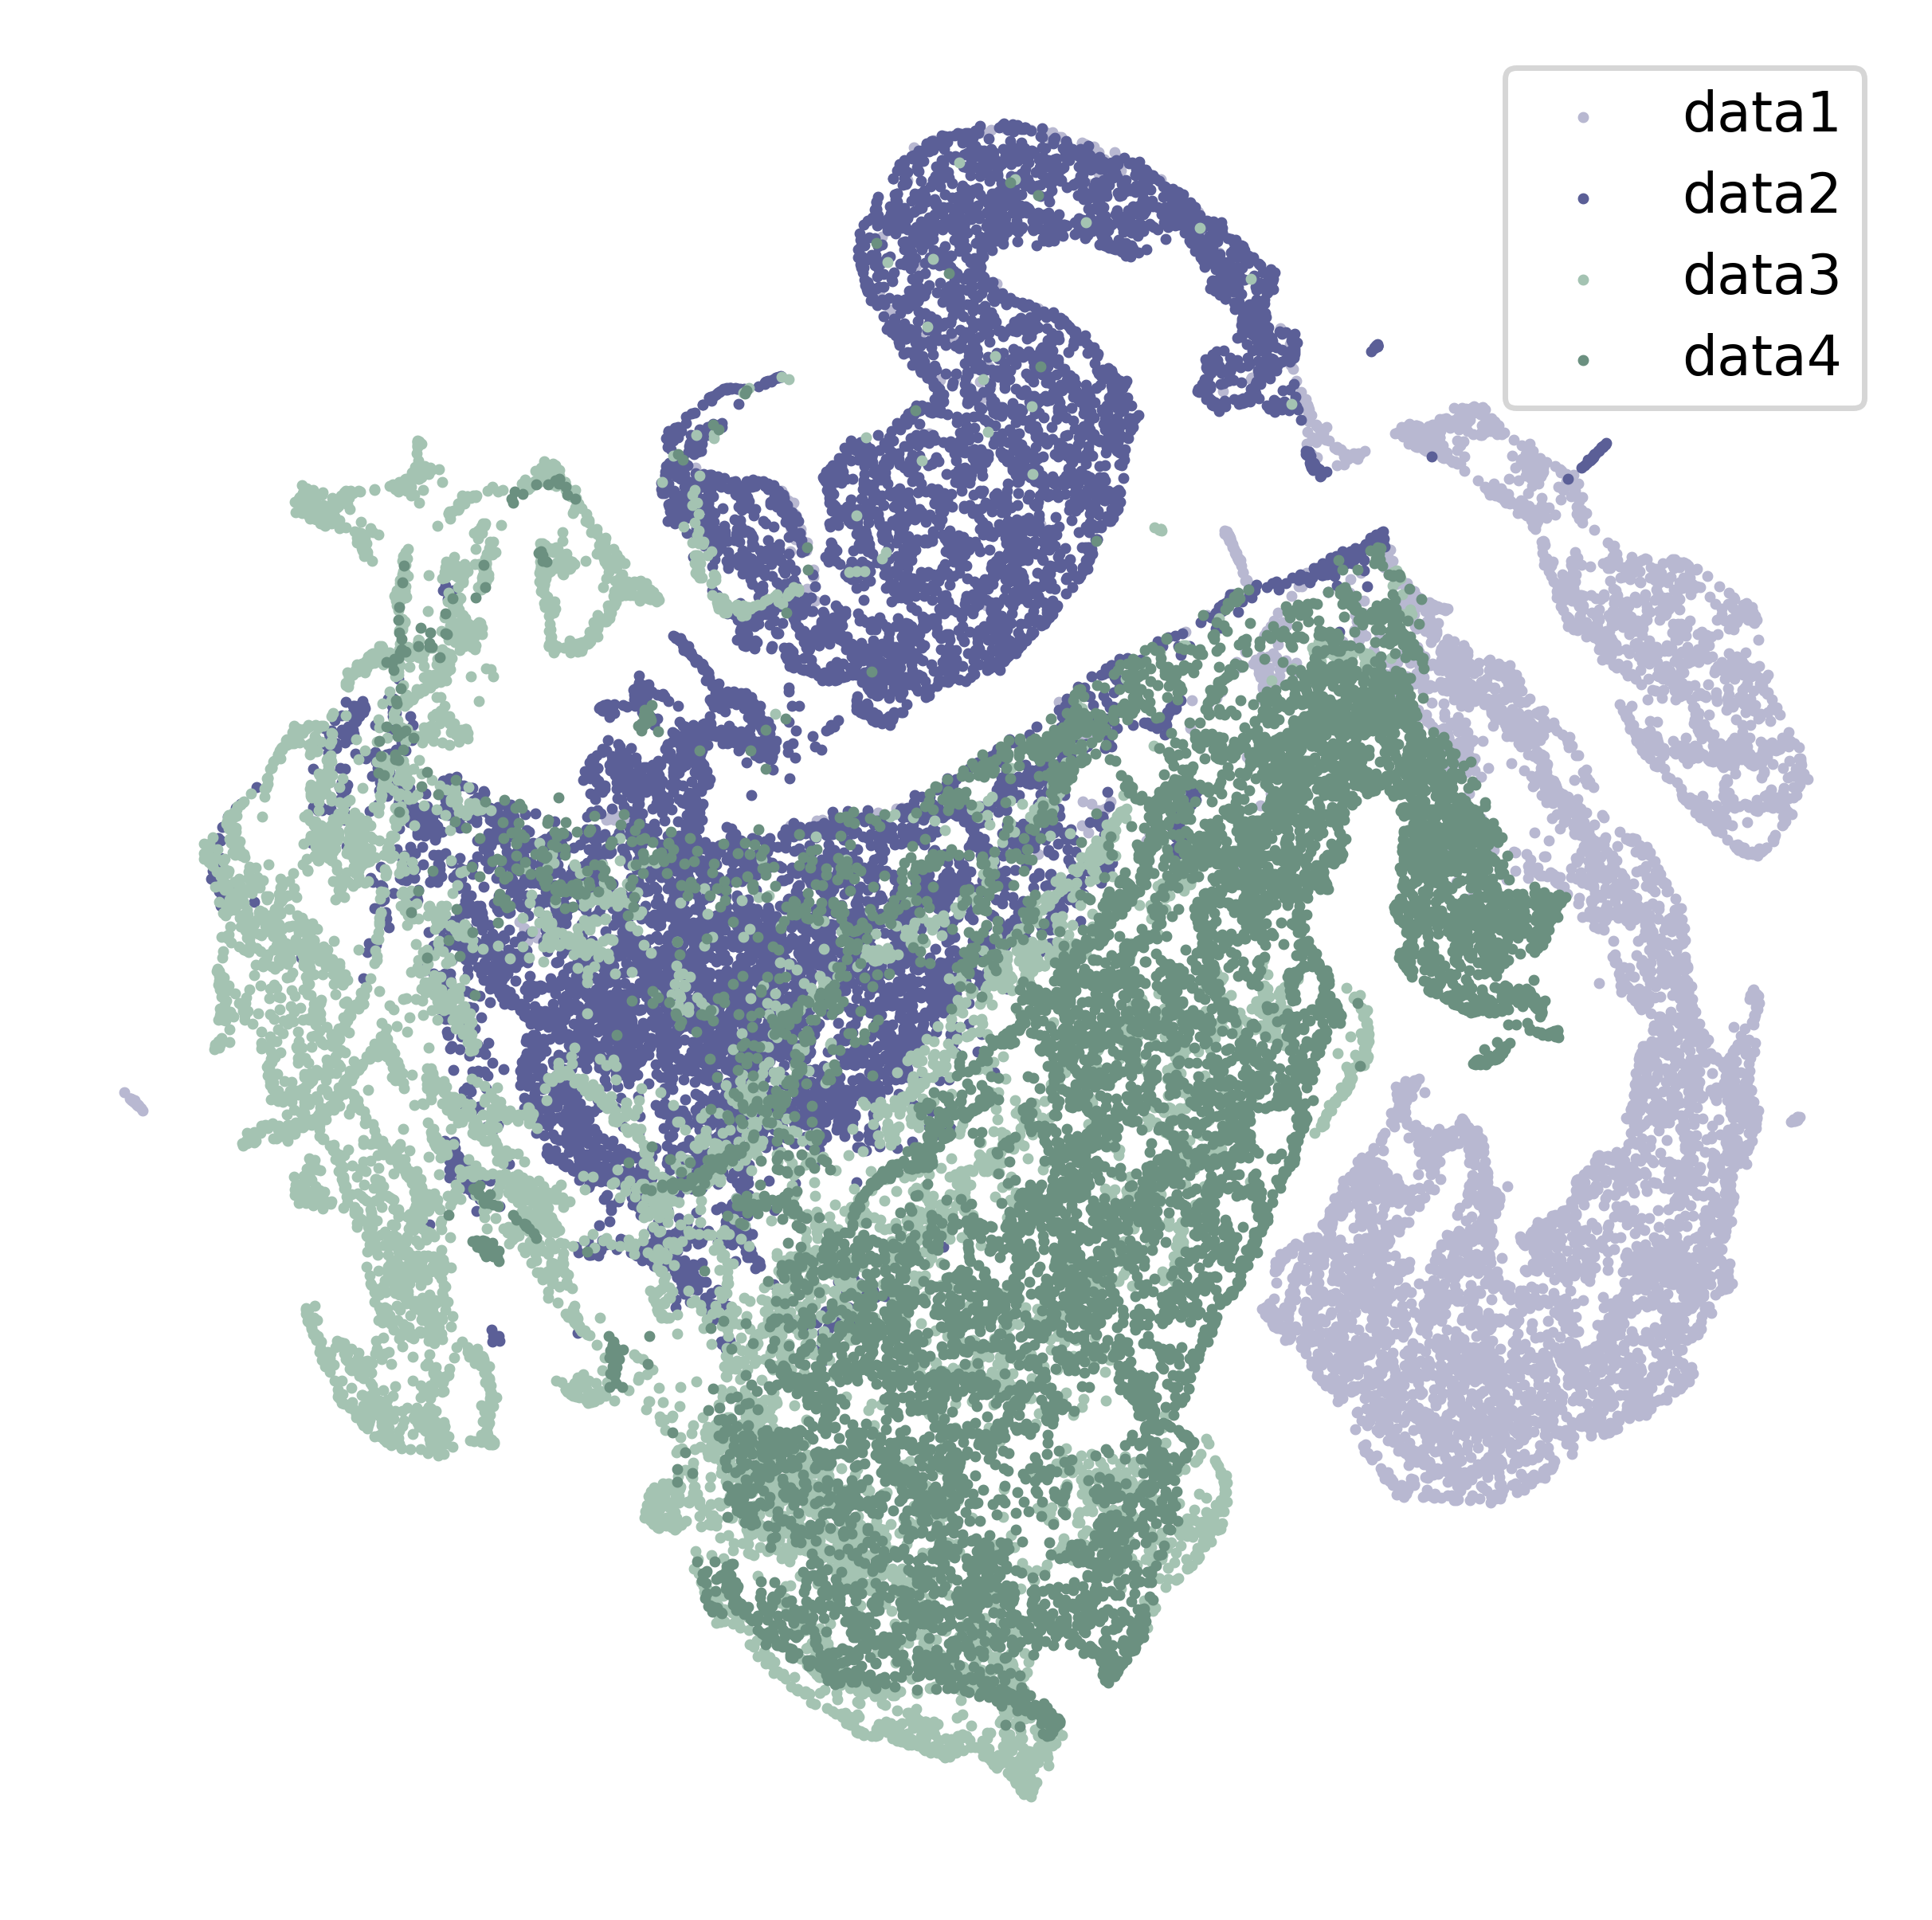

In [6]:
plt.figure(dpi=500,figsize=(6,6))
color_list = ['#B8B8D1','#5B5F97','#A4C3B2','#6B9080']
for j,i in enumerate(adata_all_immune_scRNA.obs['sample'].unique()):
    plt.scatter(adata_all_immune_scRNA.obsm['X_umap'][adata_all_immune_scRNA.obs['sample']==i,0],
                adata_all_immune_scRNA.obsm['X_umap'][adata_all_immune_scRNA.obs['sample']==i,1],
                c = color_list[j],
                s=1
               )
plt.legend(adata_all_immune_scRNA.obs['sample'].unique())
plt.axis('off')

/tmp/ipykernel_1180984/3870822176.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_all_immune_scRNA,resolution=0.12)


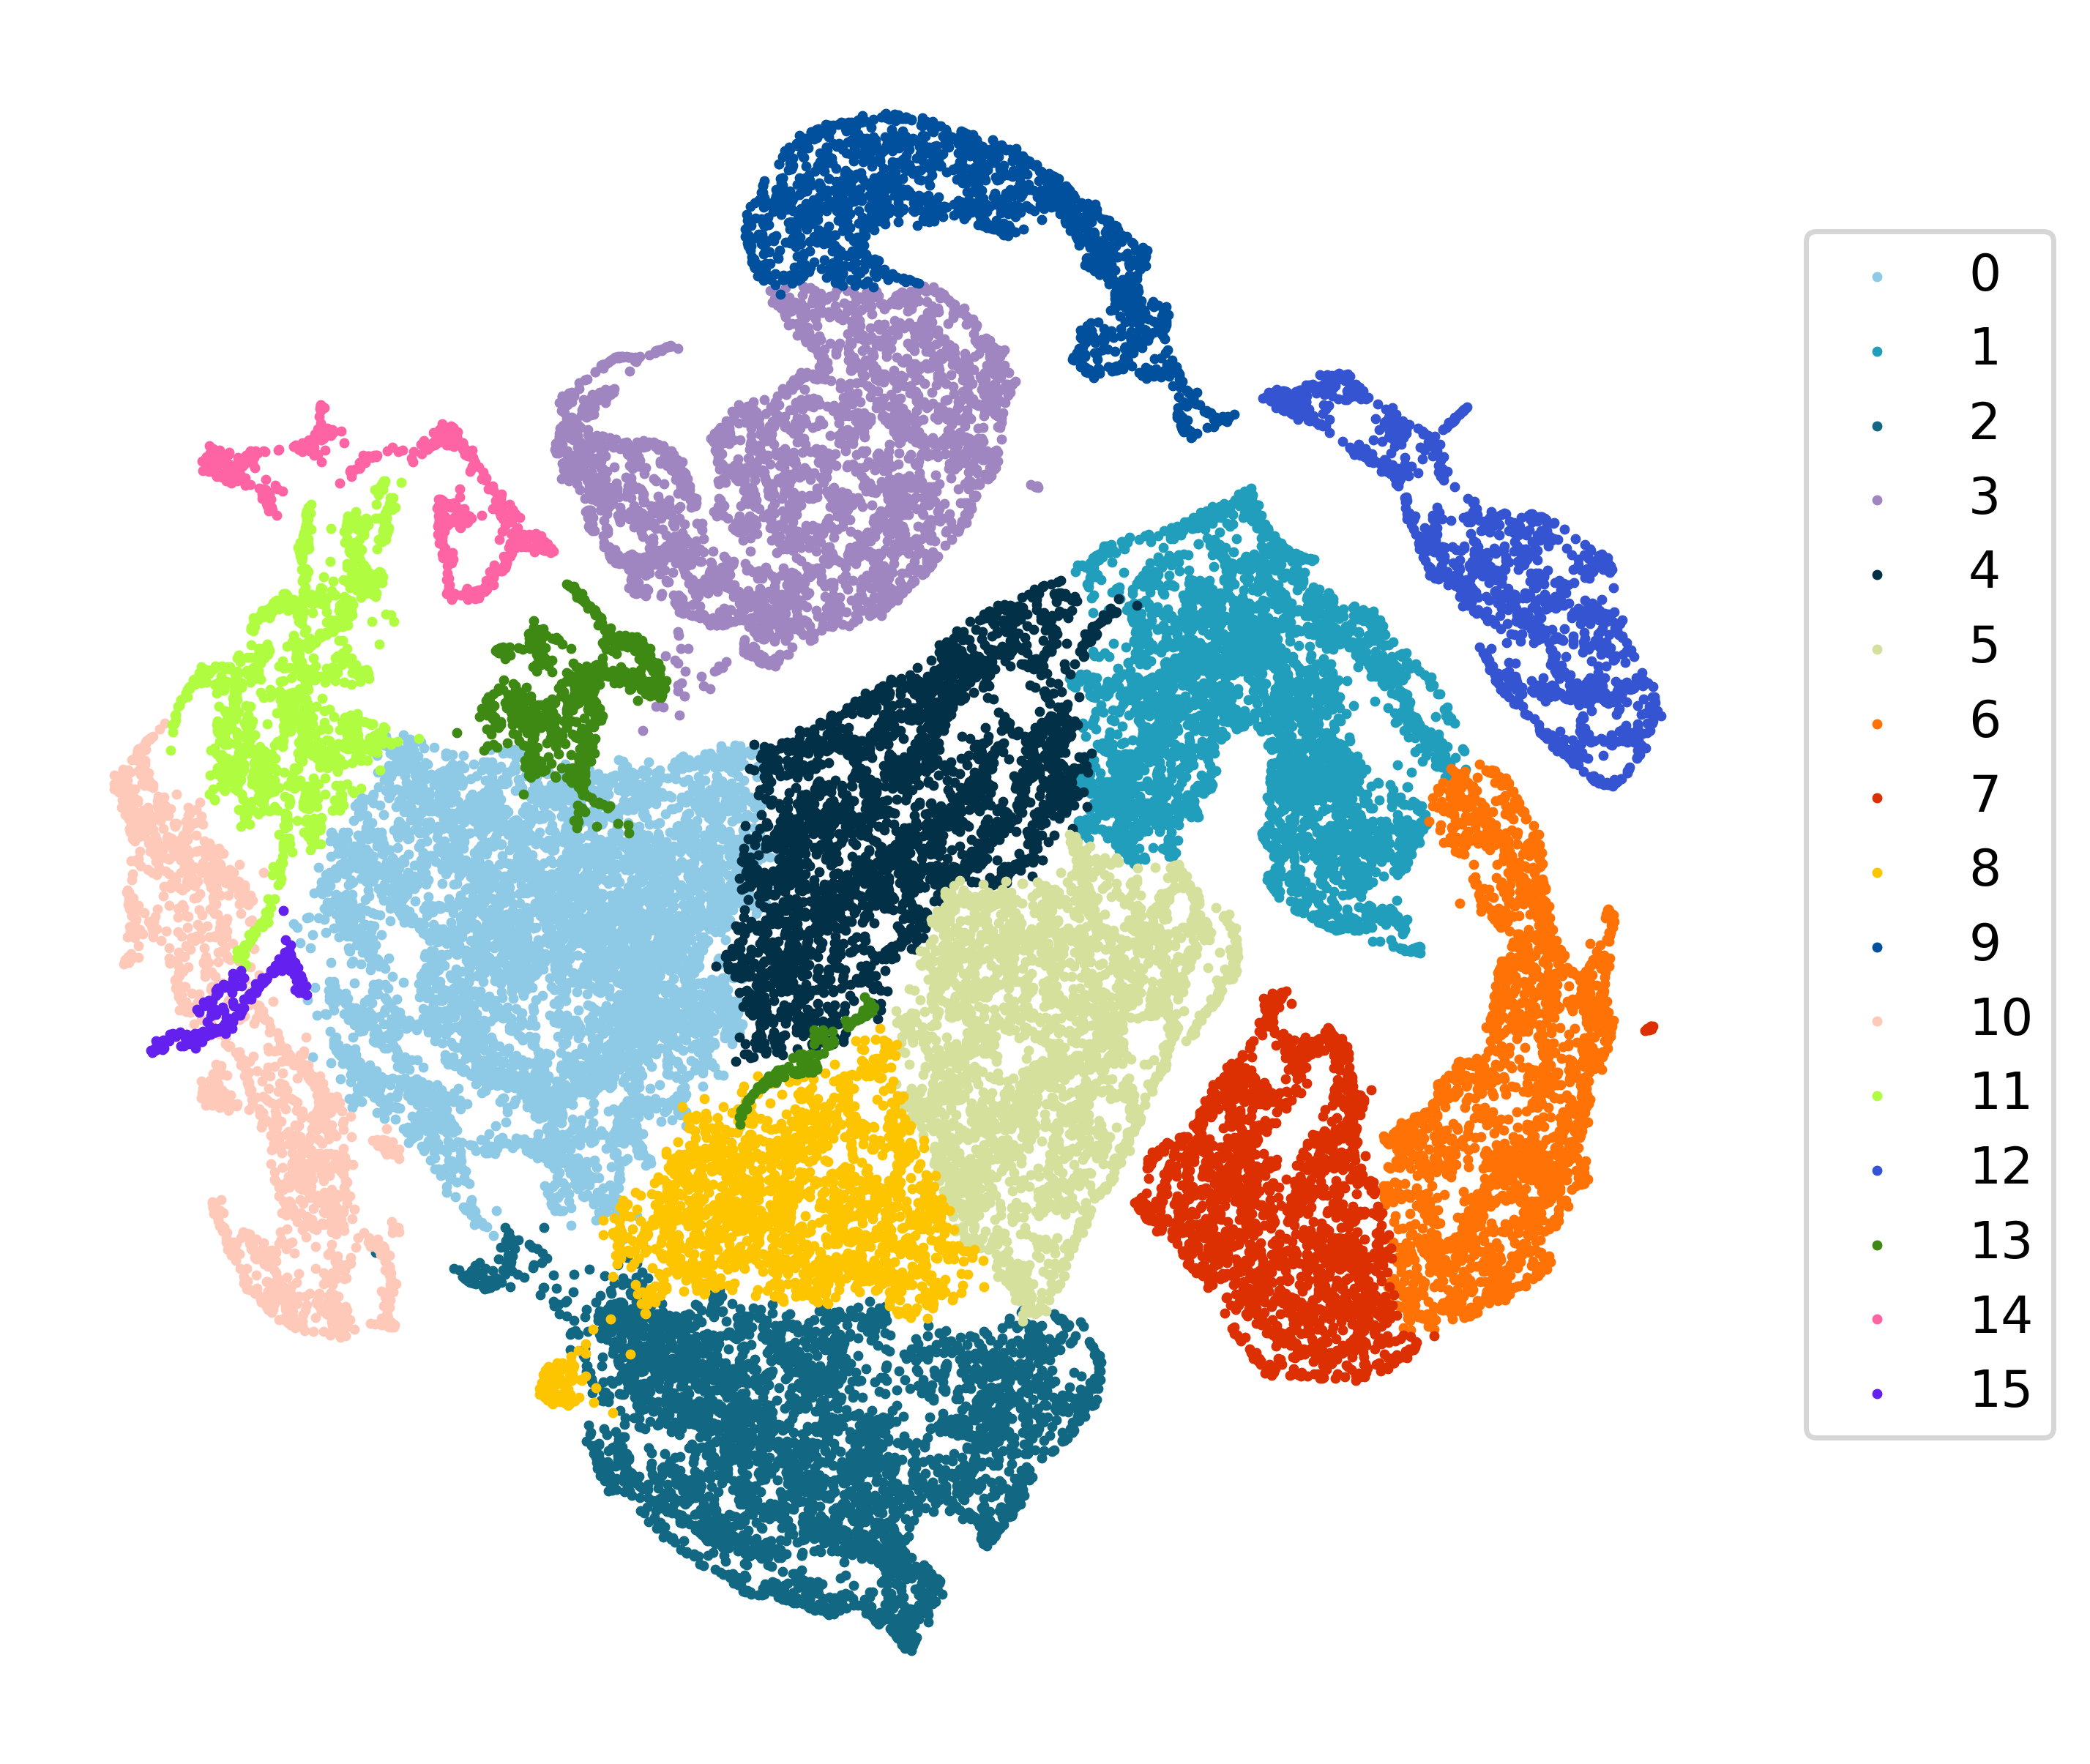

In [8]:
sc.tl.leiden(adata_all_immune_scRNA,resolution=0.12)
plt.figure(dpi=500,figsize=(6,6))
color_list =['#8ecae6',
            '#219ebc',
            '#126782',
            '#9f86c0',              
            '#023047',                     
            '#d4e09b',
            '#FE7206',
            '#dc2f02',                                                
            '#fdc500',
            '#00509d',  
            '#ffc9b9',   
            '#affc41', 
            '#3454D1',
            '#3E8914',
            '#FE64A3',
            '#6320EE',
            '#26F0F1',
            '#F25C54'
            ]
for j,i in enumerate(['0', '1', '2', '3', '4','5','6','7','8','9','10','11', '12', '13', '14', '15']):
    plt.scatter(adata_all_immune_scRNA.obsm['X_umap'][adata_all_immune_scRNA.obs['leiden']==i,0],
                adata_all_immune_scRNA.obsm['X_umap'][adata_all_immune_scRNA.obs['leiden']==i,1],
                c = color_list[j],
                s=1
               )
plt.axis('off')

plt.legend(['0', '1', '2', '3', '4','5','6','7','8','9','10','11', '12', '13', '14', '15'],bbox_to_anchor=(1.2,0.9))

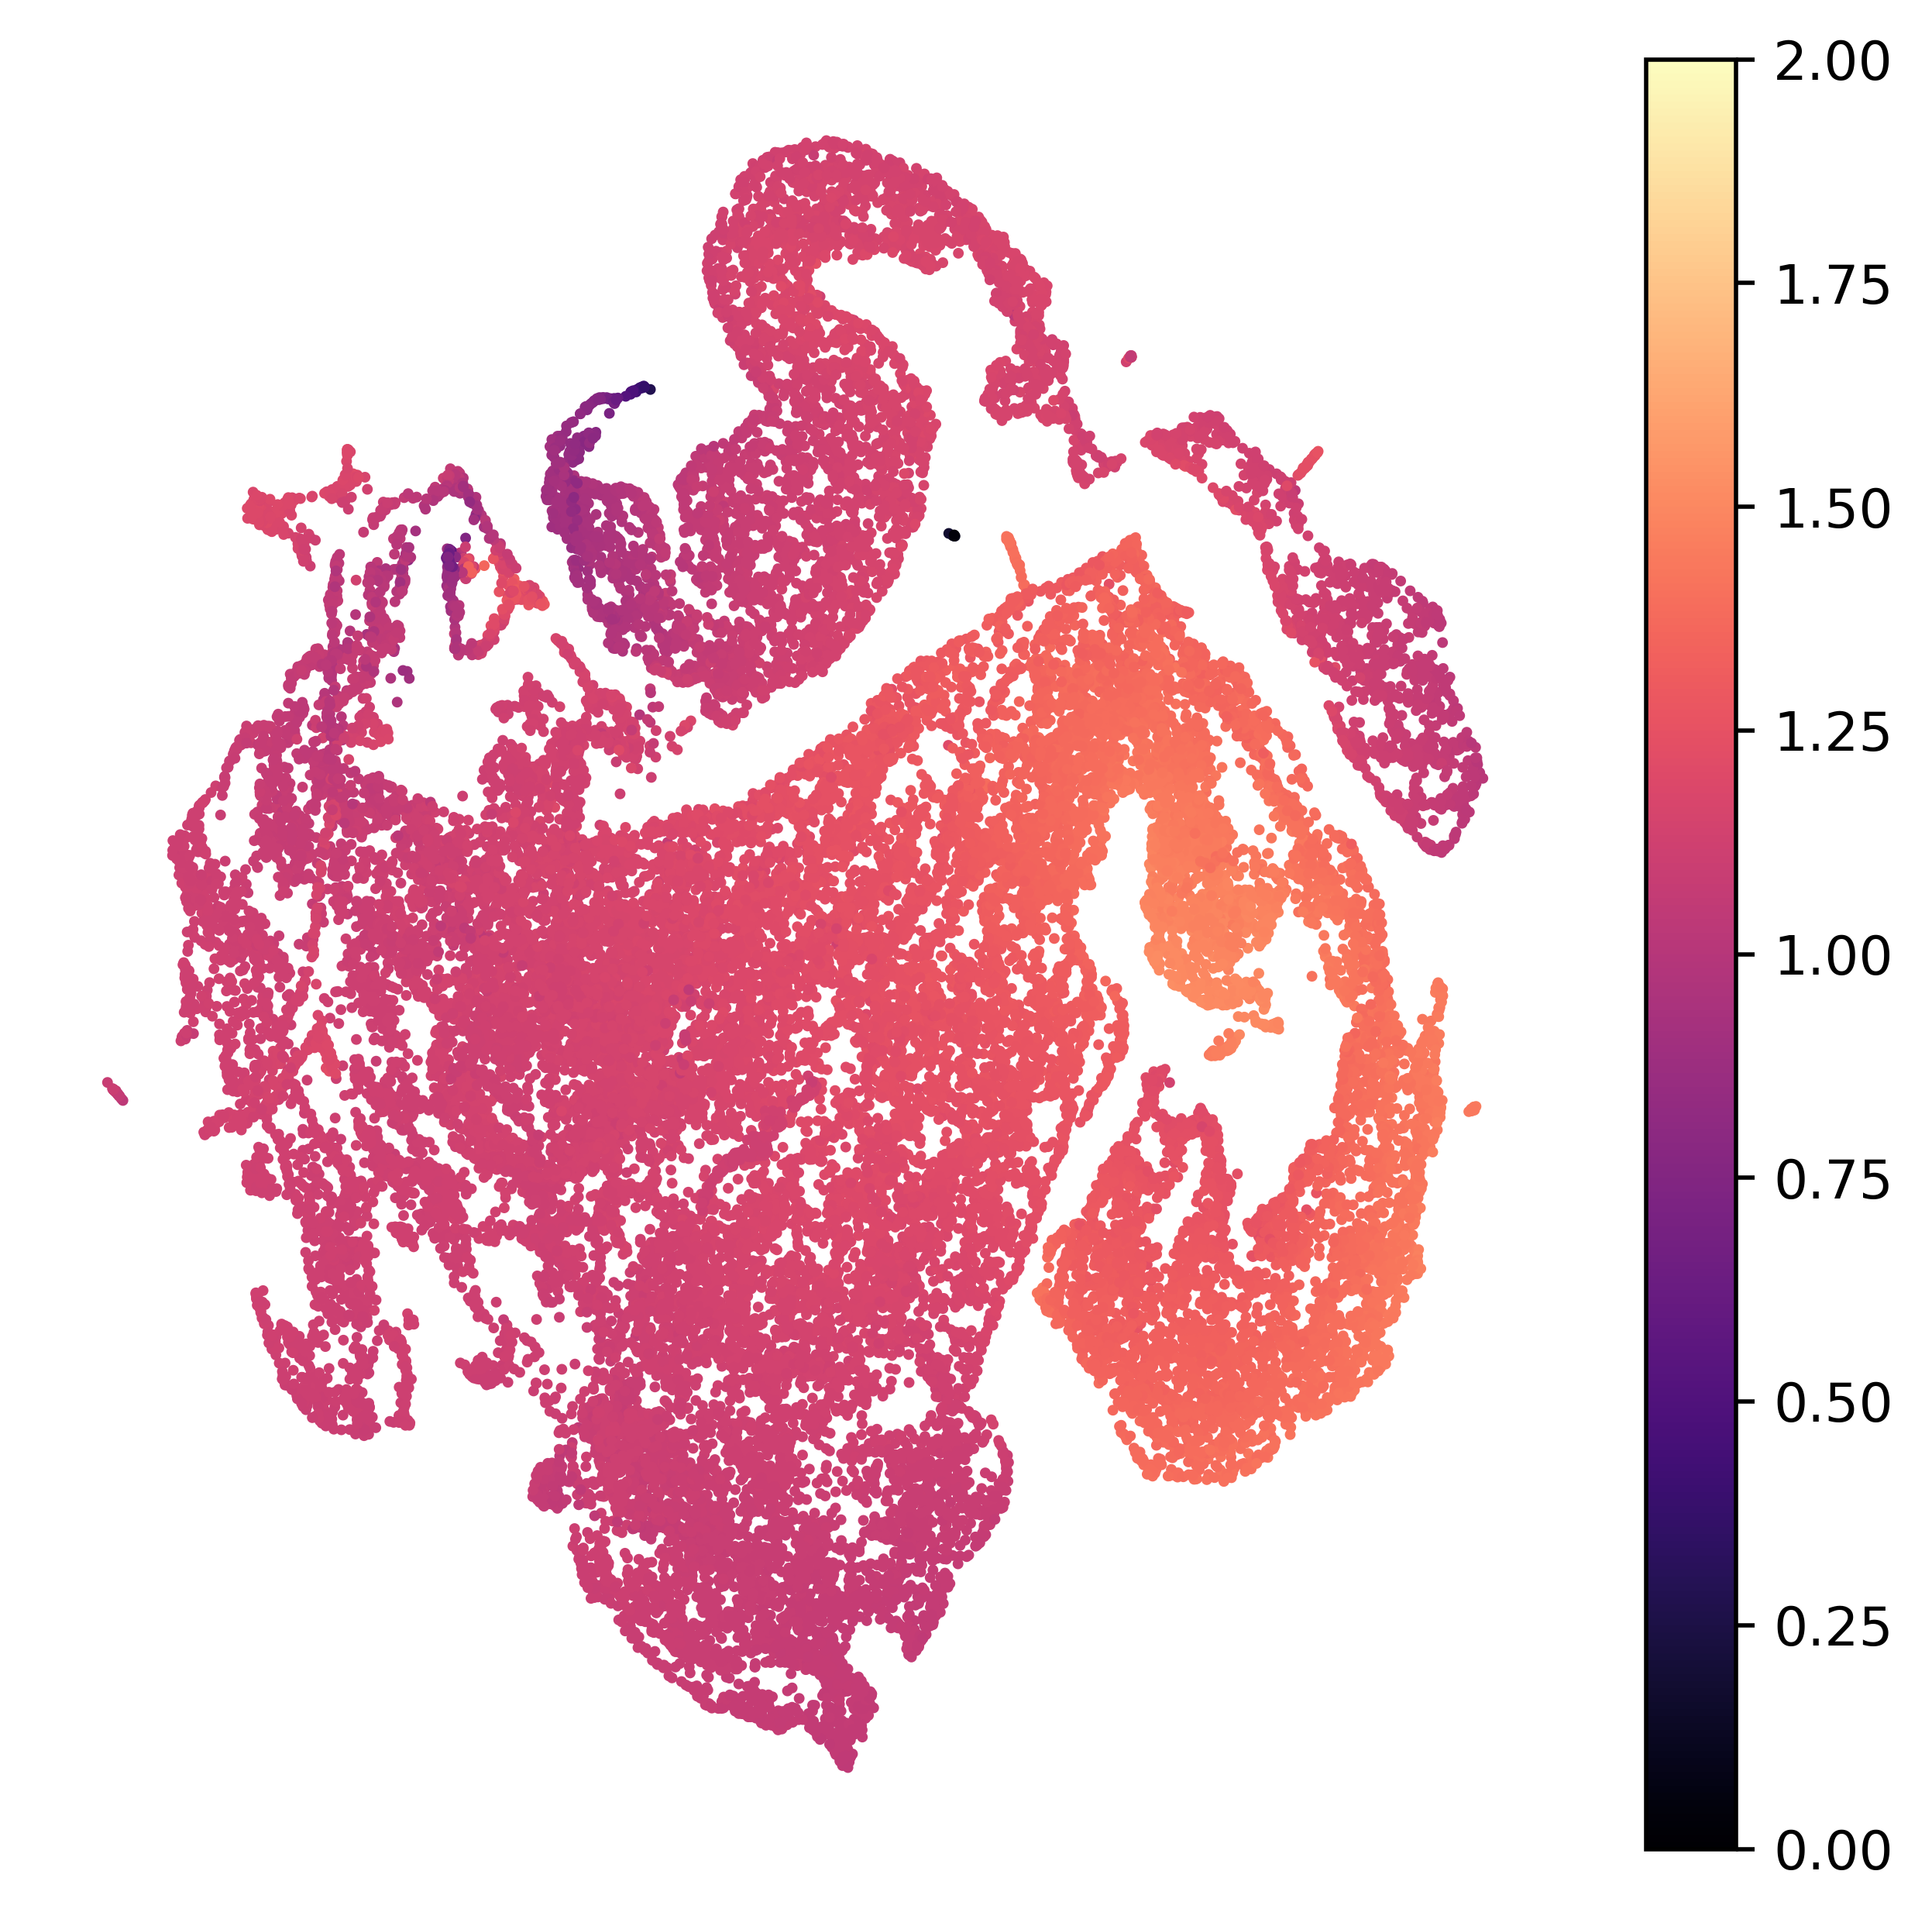

In [9]:
plt.figure(dpi=500,figsize=(6.3,6))
plt.scatter(adata_all_immune_scRNA.obsm['X_umap'][:,0],
            adata_all_immune_scRNA.obsm['X_umap'][:,1],
            c = adata_all_immune_scRNA[:,'FOXP3'].to_df().values,
            cmap='magma',
            vmin=0,
            vmax=2,
            s=1
           )
plt.axis('off')
plt.colorbar()

/tmp/ipykernel_1180984/3770386442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_.obs.groupby(['qv_bin', annotation_column])


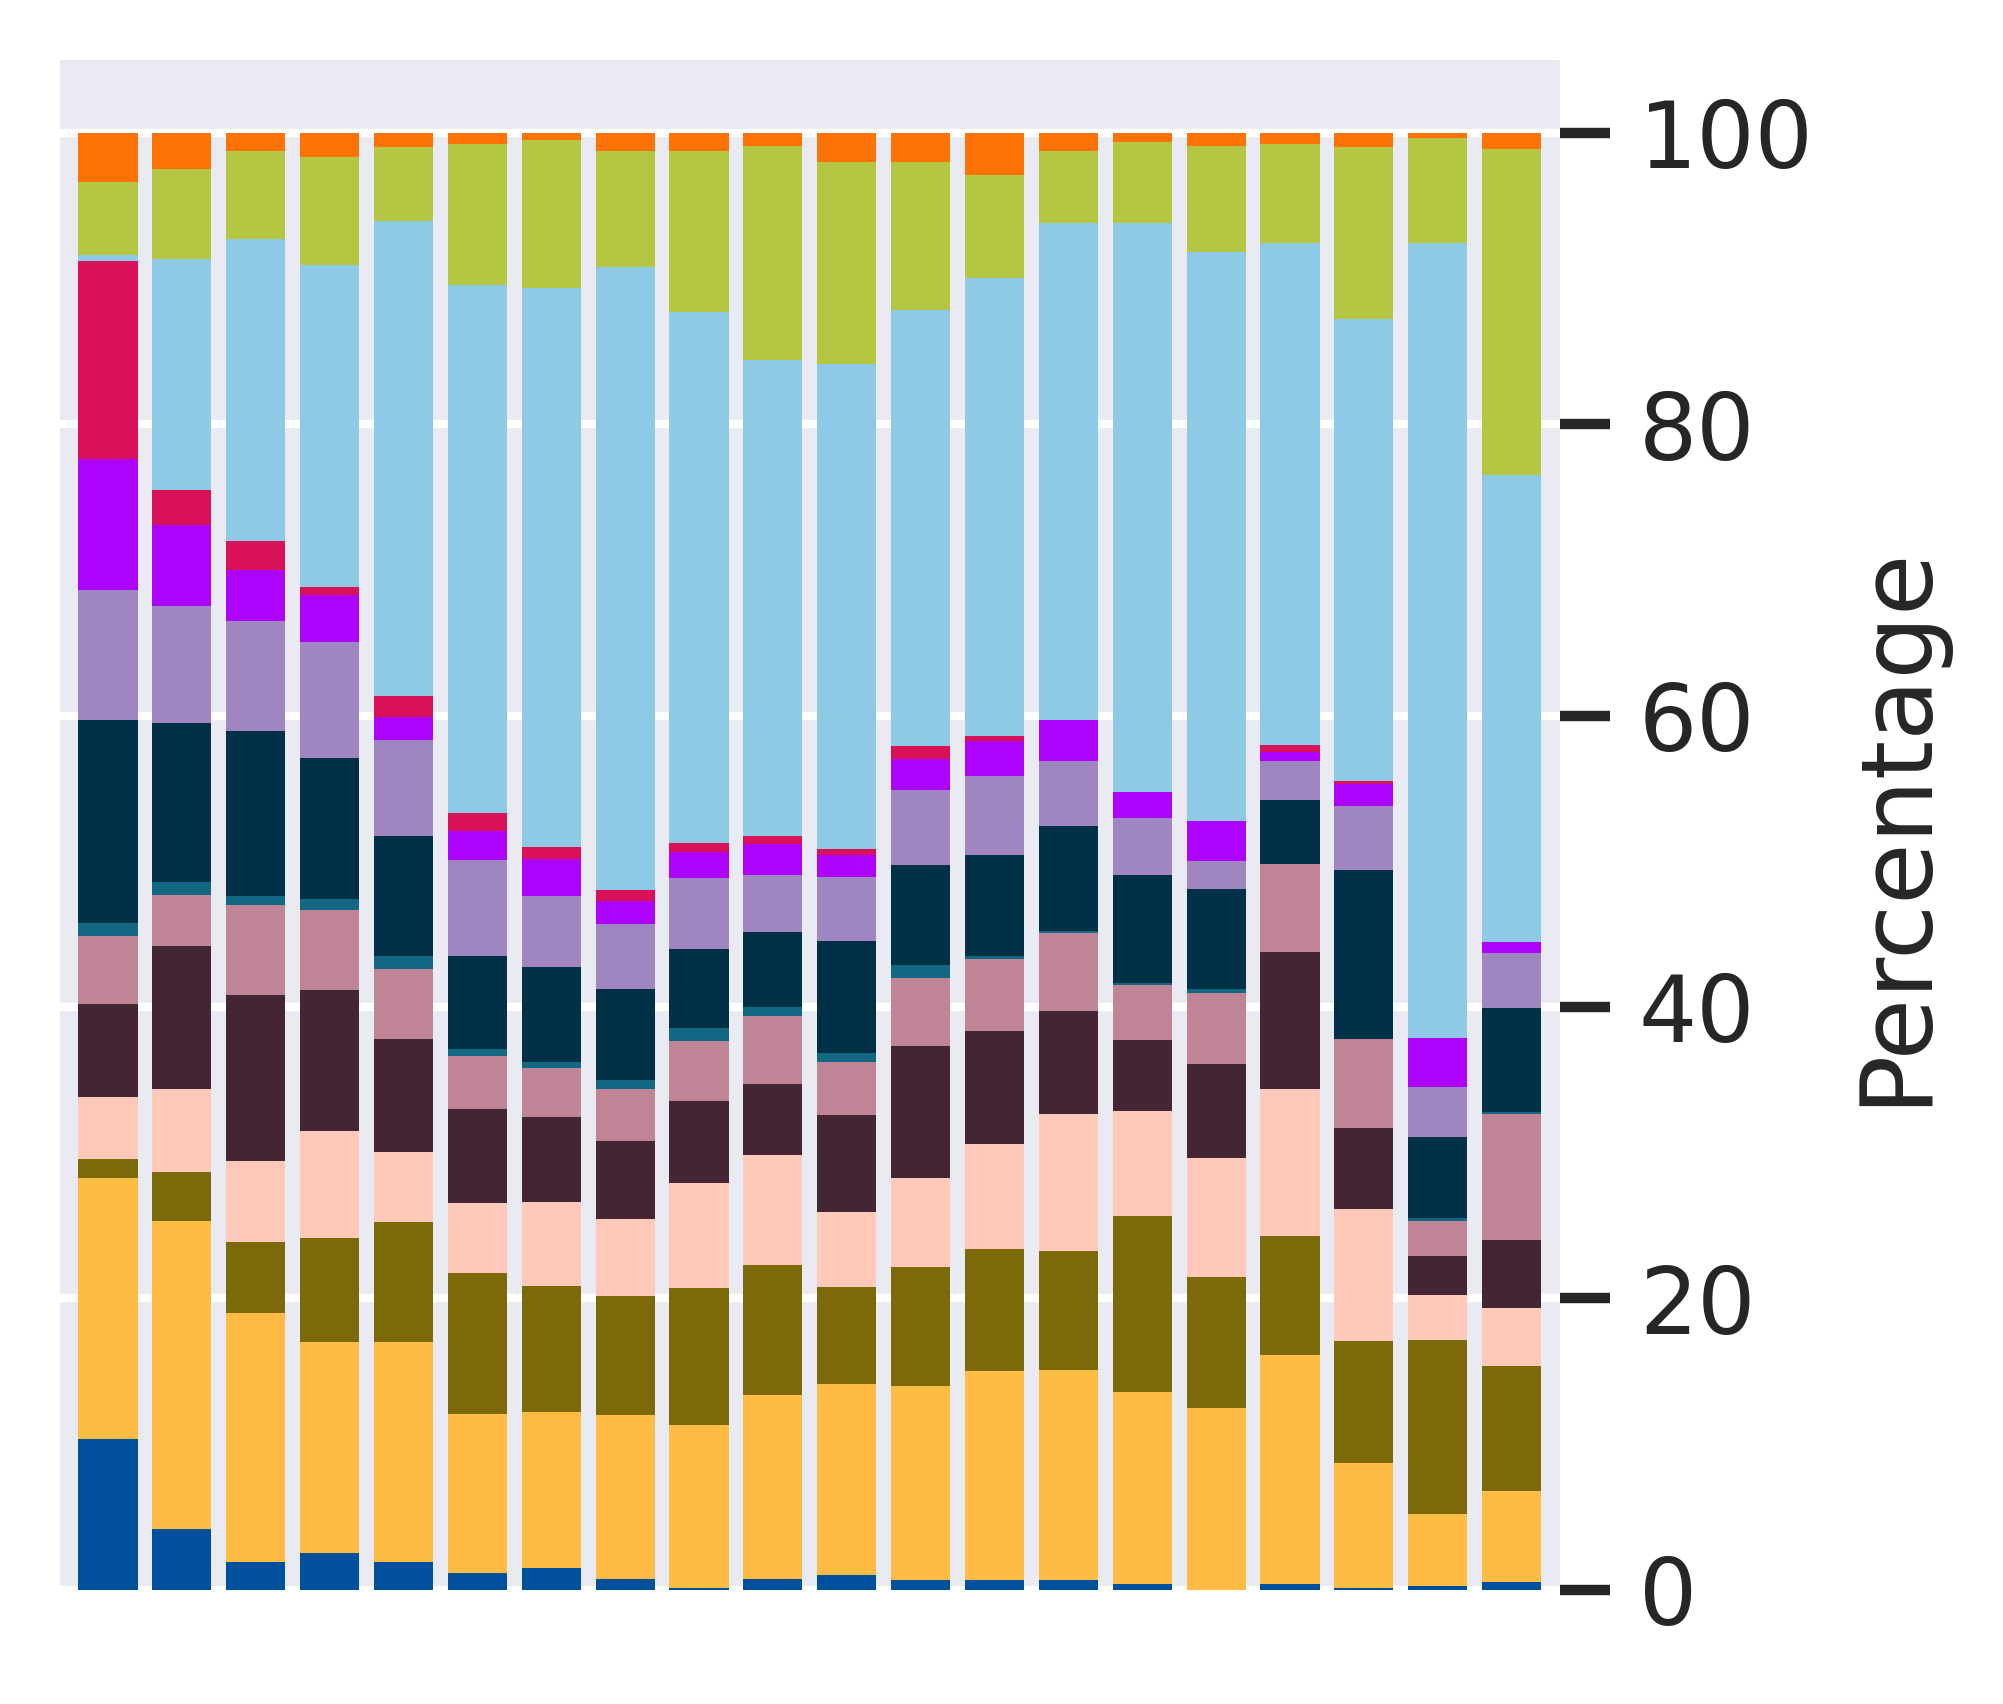

/tmp/ipykernel_1180984/3770386442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_.obs.groupby(['qv_bin', annotation_column])


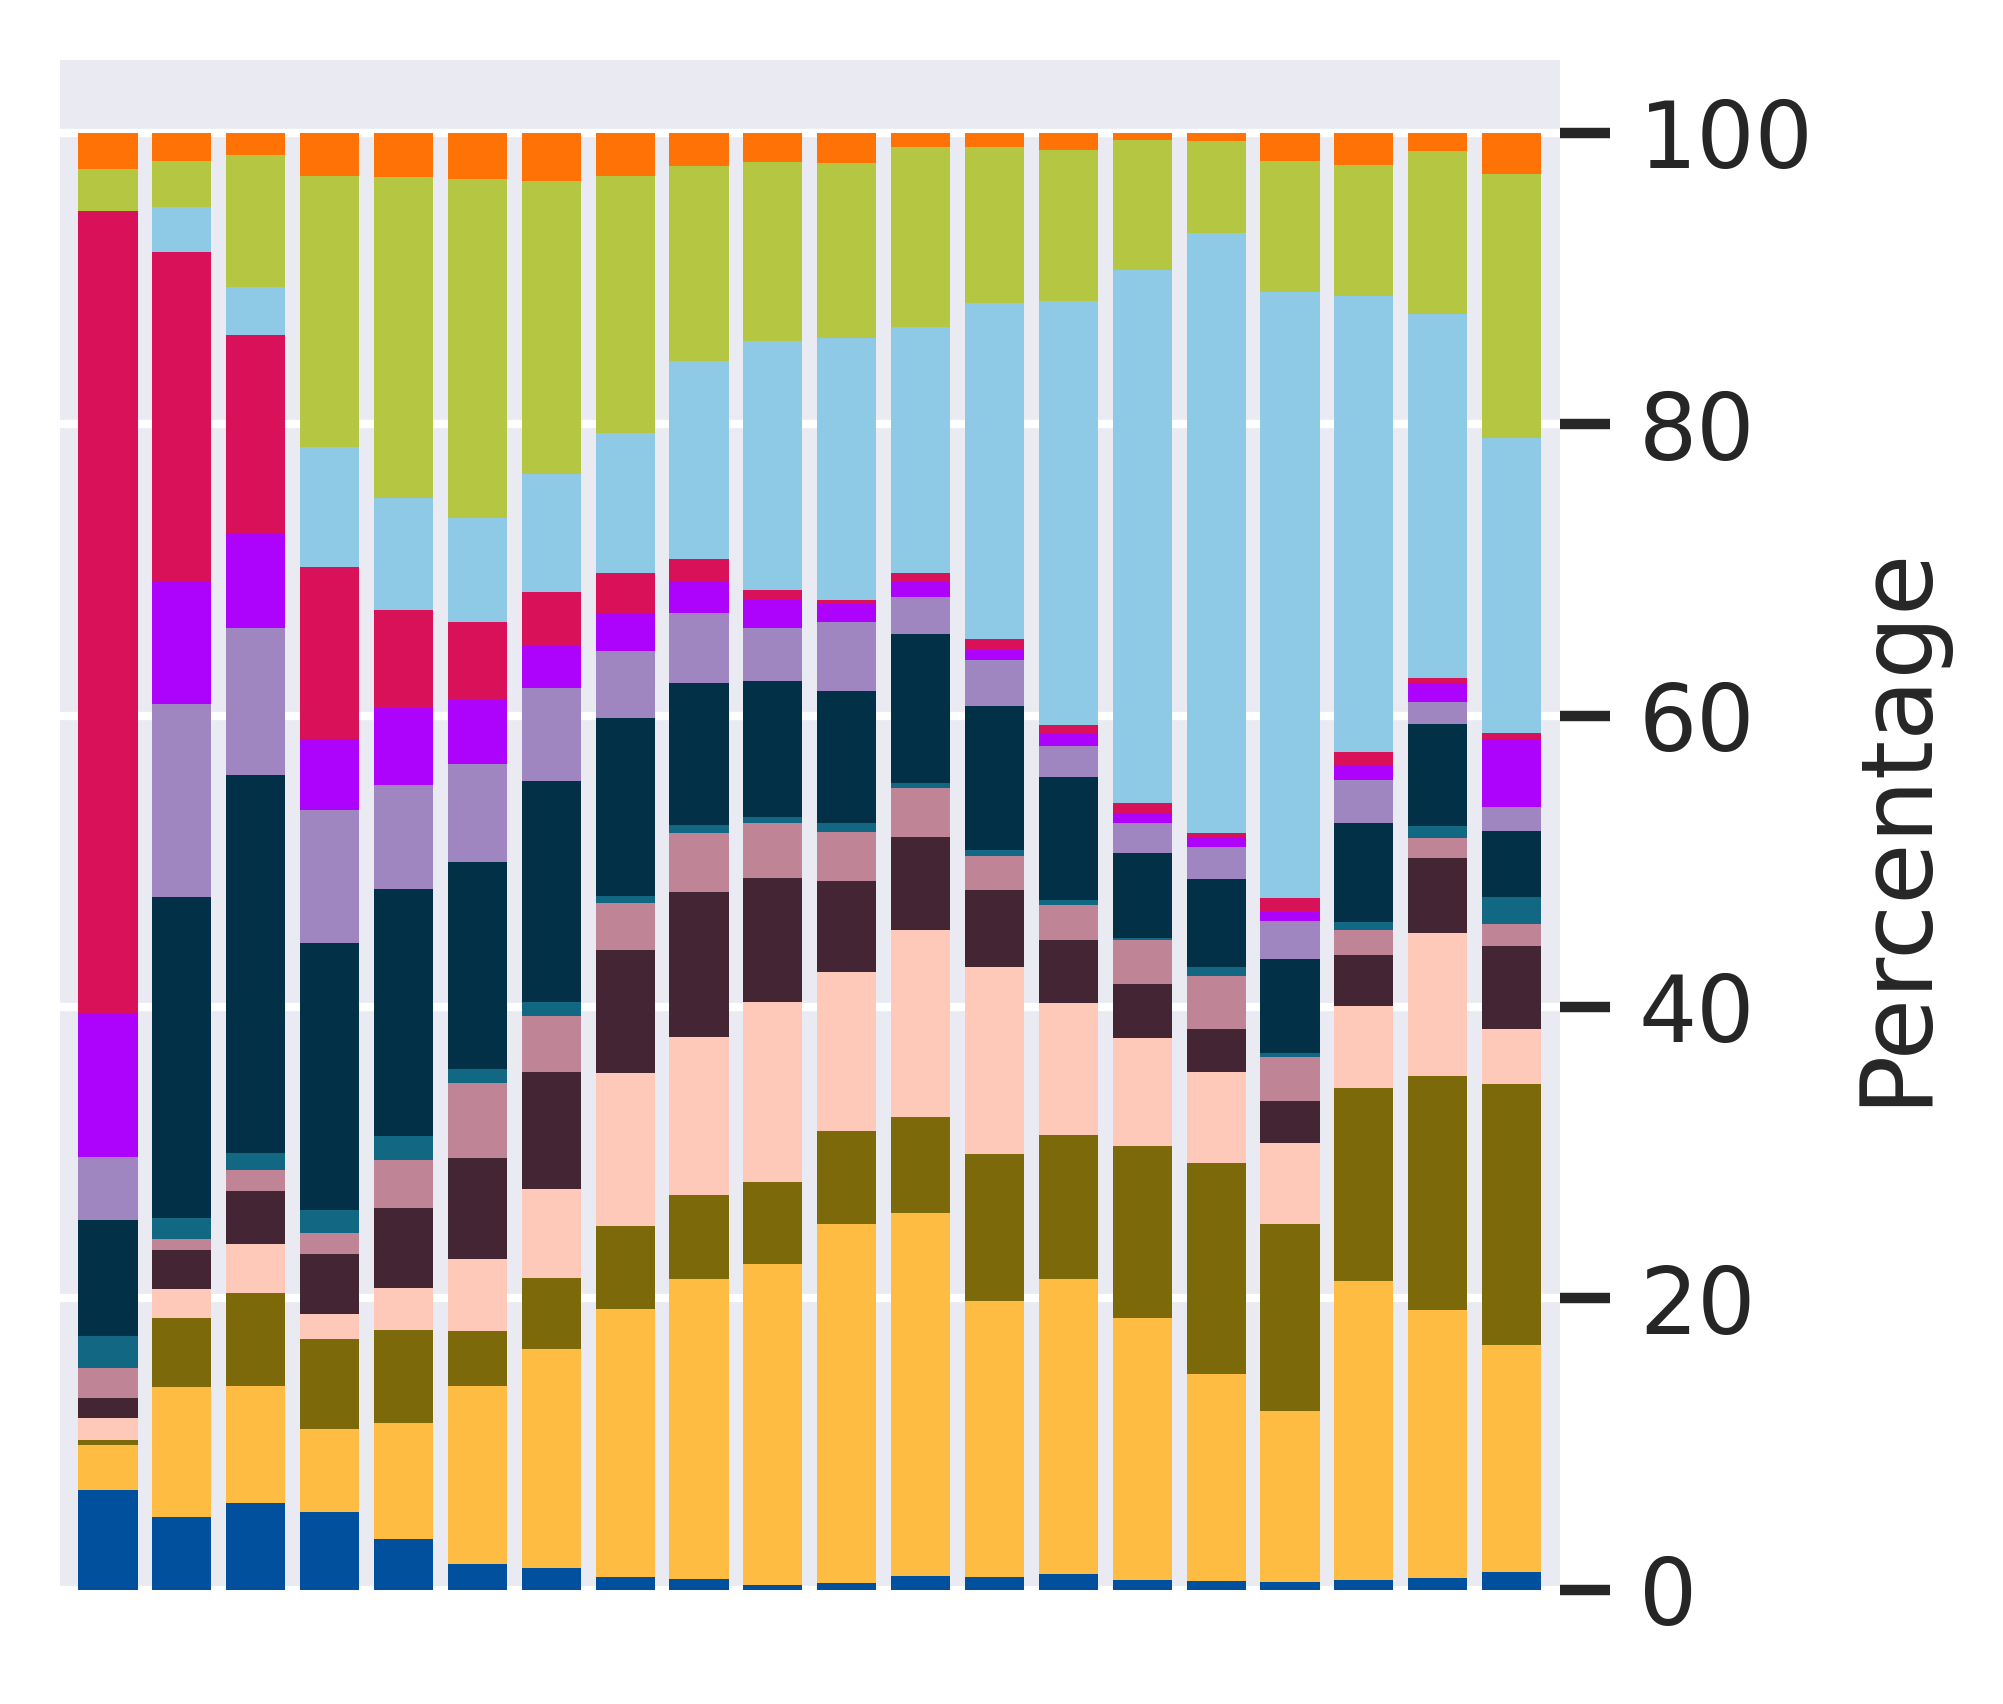

/tmp/ipykernel_1180984/3770386442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_.obs.groupby(['qv_bin', annotation_column])


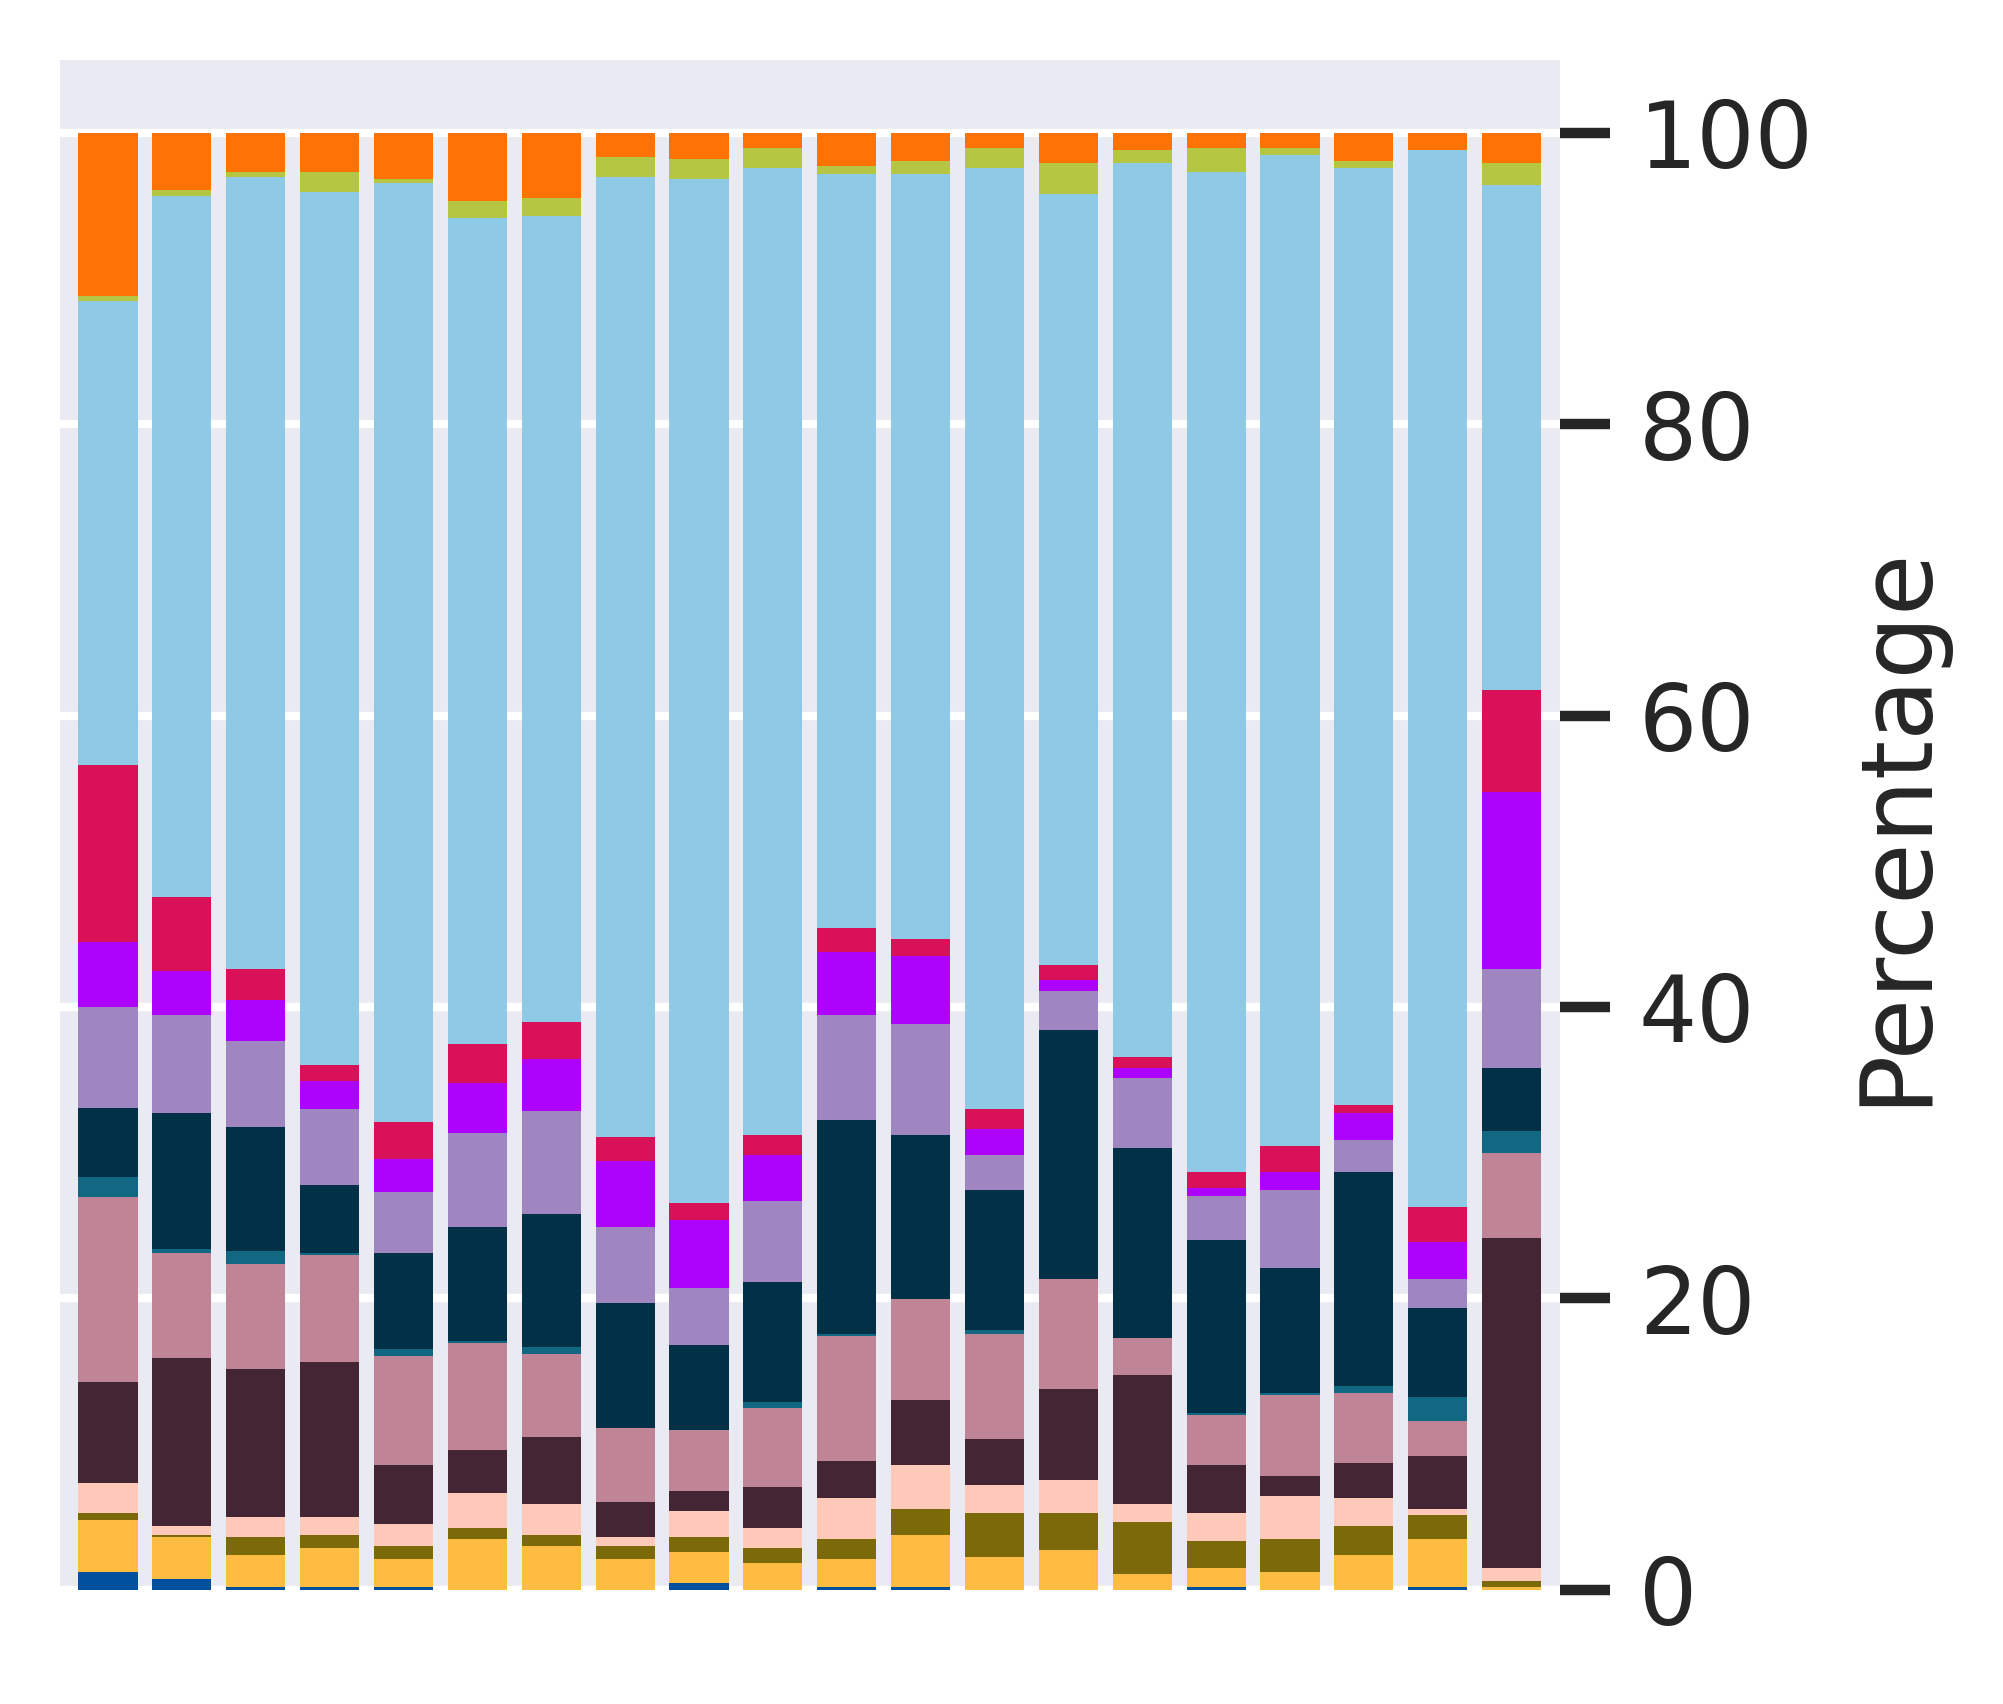

/tmp/ipykernel_1180984/3770386442.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_.obs.groupby(['qv_bin', annotation_column])


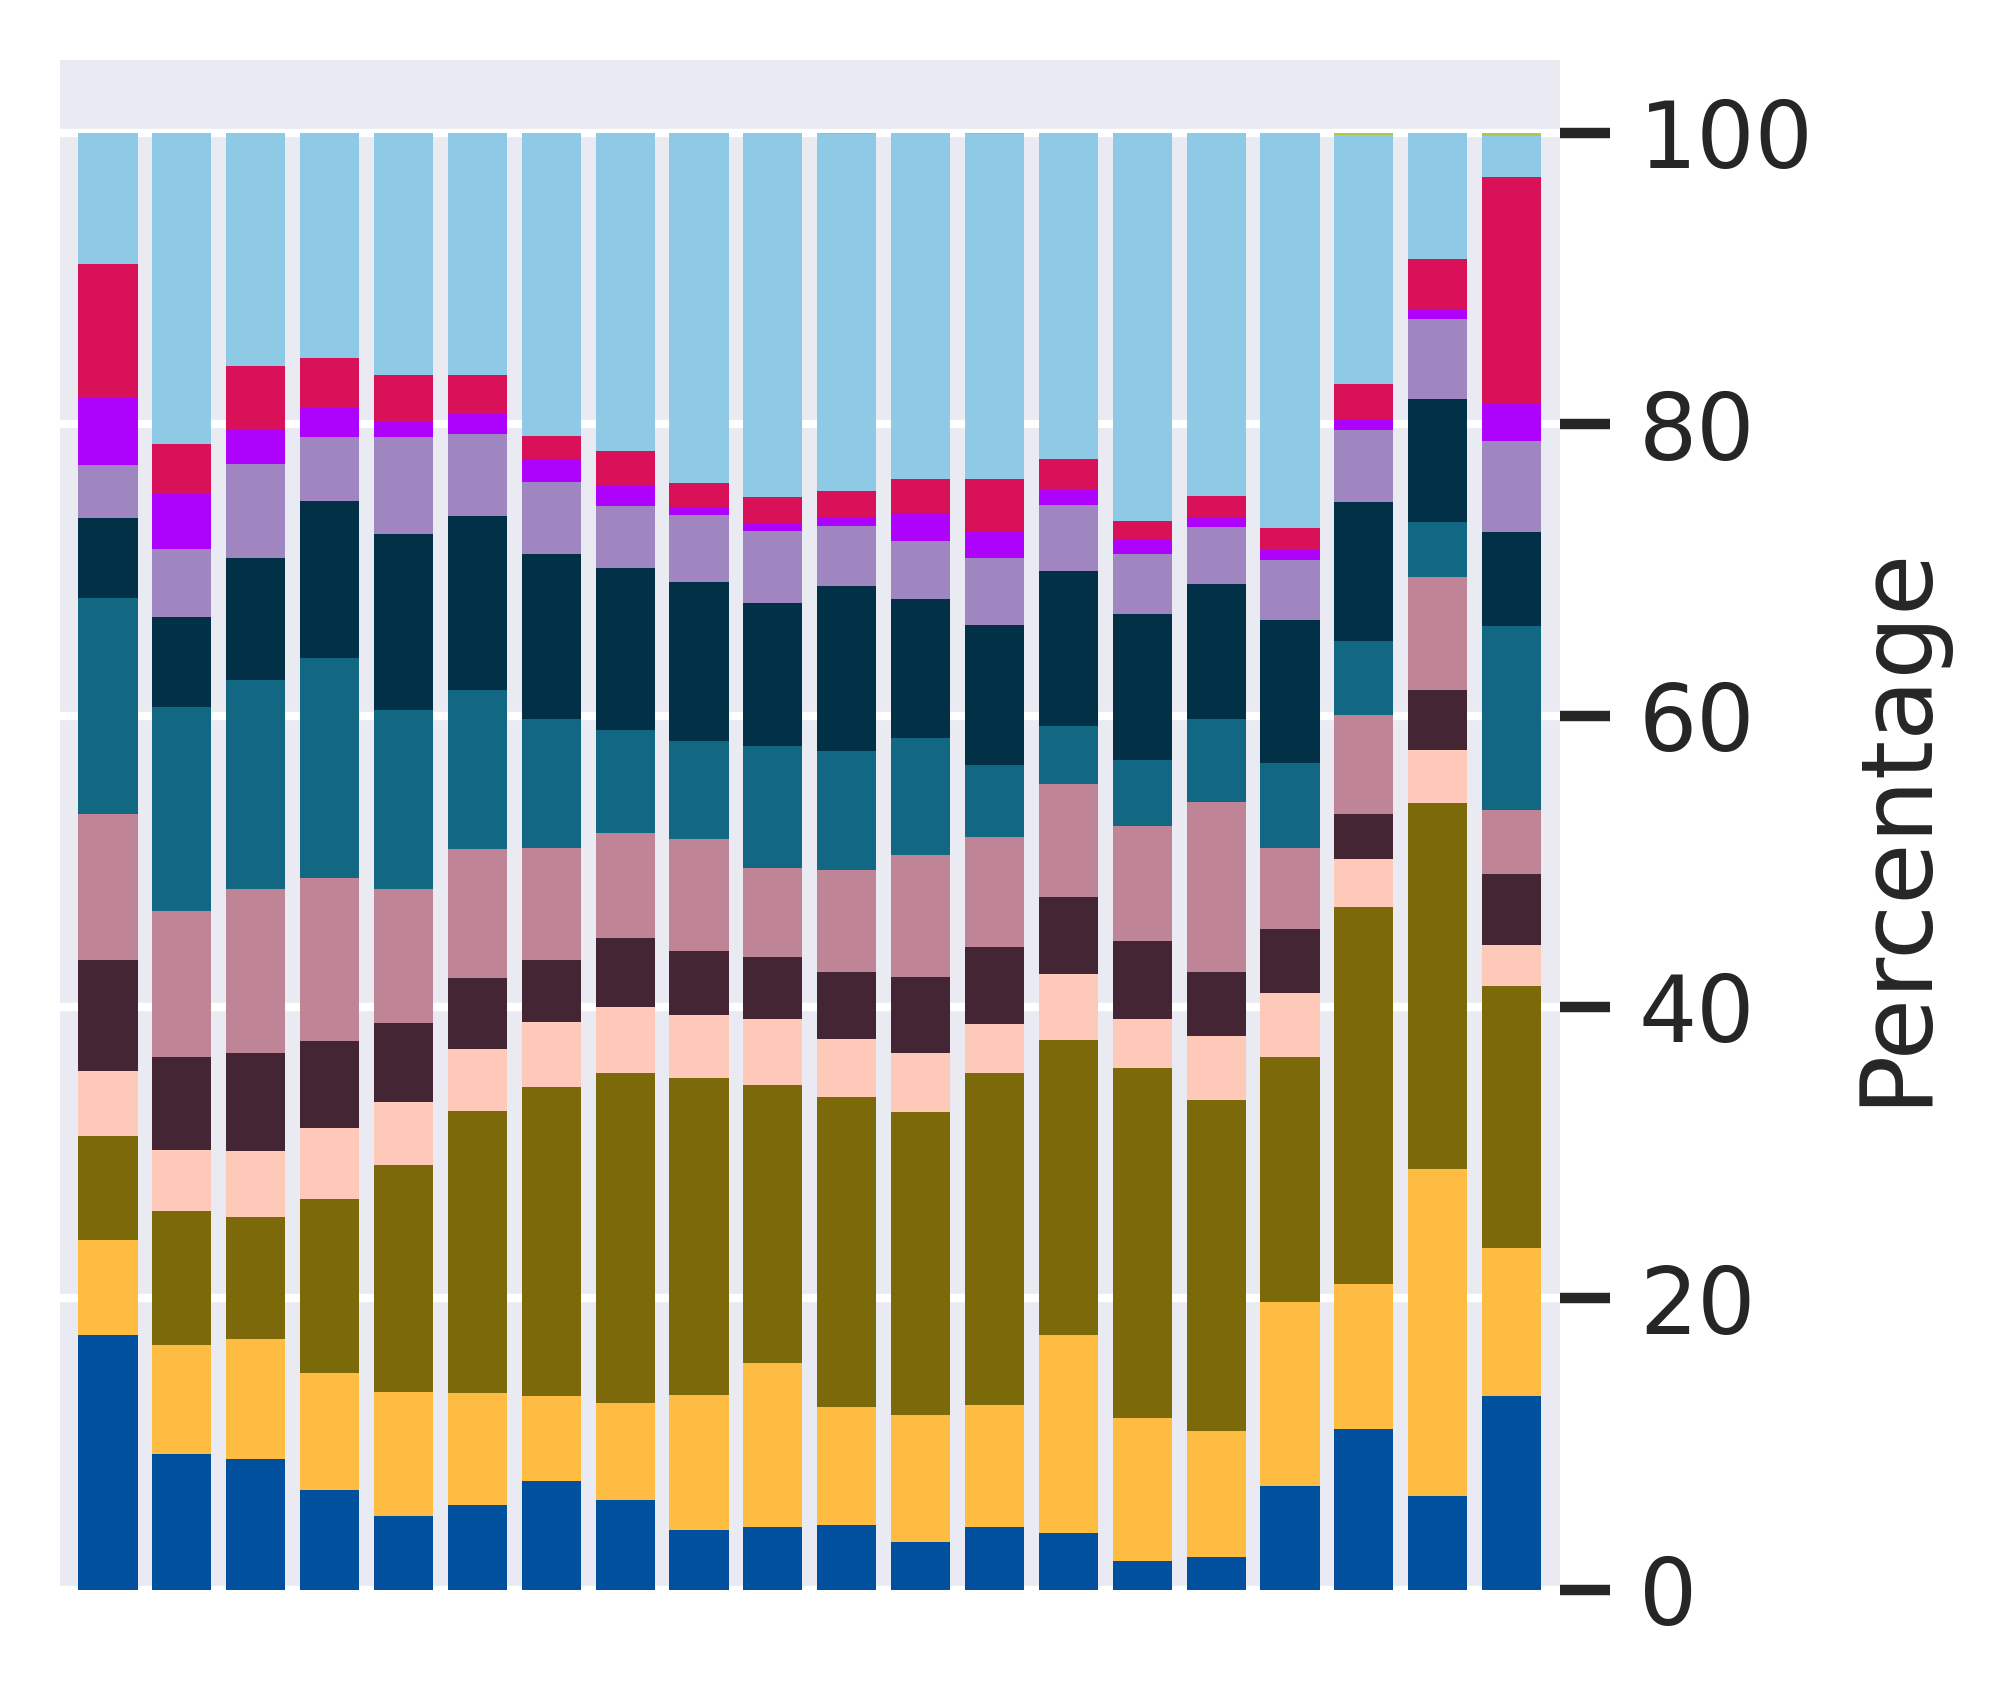

In [36]:
for adata_ in [adata1,adata2,adata3,adata4]:

    annotation_column = 'codex_type_label'  # Replace with the actual name of your annotation column


    # Step 1: Bin the qv values into equal-width bins
    adata_.obs['qv_bin'] = pd.qcut(adata_.obsm['v_values'].flatten(), q=20)  # Adjust q for the number of bins

    # Step 2: Calculate the percentage of each annotation in each bin
    percentage_df = (
        adata_.obs.groupby(['qv_bin', annotation_column])
        .size()
        .reset_index(name='count')
        .pivot(index='qv_bin', columns=annotation_column, values='count')
    )

    percentage_df = percentage_df.div(percentage_df.sum(axis=1), axis=0) * 100


    color_mapping = {'Tumor':'#8ecae6',
    'CD8 T cells':'#7c6a0a',
    'INFg+':'#126782',
    'Neutrophils':'#ad03fc',
    'CD4 T cells':'#ffbc42',
    'Stroma Uncharacterized':'#d81159',
    'B cells':'#00509d',
    'Macrophages M2-like':'#9f86c0',
    'Macrophages':'#023047',
    'Fibroblasts':'#c08497',
    'Endothelial cells':'#432534',
    'Dendritic cells':'#ffc9b9',
    'Tumor Inos':'#b5c742',
    'Unknown':'#FE7206'}


    plt.rcParams['axes.edgecolor'] = 'none'  # Remove axis border
    plt.rcParams['patch.linewidth'] = 0    # Remove bar edge lines
    plt.rcParams['figure.facecolor'] = 'white'  # Change background to white

    fig, ax = plt.subplots(figsize=(3.5, 3), dpi=600)
    # Plot the data
    percentage_df.plot(kind='bar', stacked=True, edgecolor=None,color=[color_mapping[col] for col in percentage_df.columns], width=0.8, ax=ax)

    # Move y-axis to the right
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    # Customize the plot
    plt.title('')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
    plt.legend(title='Annotation', bbox_to_anchor=(1.3, 1), loc='upper left')
    ax.get_legend().remove()
    plt.xticks([])
    plt.tight_layout()
    plt.show()

In [7]:
adata_scRNA1 = anndata.AnnData(adata1.obsm['generated_expr'])
adata_scRNA1.obs = adata1.obs
adata_scRNA1.obsm = adata1.obsm
adata_scRNA1.var_names = select_gene
adata_scRNA1.raw = adata_scRNA1
sc.pp.normalize_total(adata_scRNA1,target_sum=1e4)
sc.pp.log1p(adata_scRNA1)
sc.tl.pca(adata_scRNA1)

adata_scRNA2 = anndata.AnnData(adata2.obsm['generated_expr'])
adata_scRNA2.obs = adata2.obs
adata_scRNA2.obsm = adata2.obsm
adata_scRNA2.var_names = select_gene
adata_scRNA2.raw = adata_scRNA2
sc.pp.normalize_total(adata_scRNA2,target_sum=1e4)
sc.pp.log1p(adata_scRNA2)
sc.tl.pca(adata_scRNA2)

adata_scRNA3 = anndata.AnnData(adata3.obsm['generated_expr'])
adata_scRNA3.obs = adata3.obs
adata_scRNA3.obsm = adata3.obsm
adata_scRNA3.var_names = select_gene
adata_scRNA3.raw = adata_scRNA3
sc.pp.normalize_total(adata_scRNA3,target_sum=1e4)
sc.pp.log1p(adata_scRNA3)
sc.tl.pca(adata_scRNA3)

adata_scRNA4 = anndata.AnnData(adata4.obsm['generated_expr'])
adata_scRNA4.obs = adata4.obs
adata_scRNA4.obsm = adata4.obsm
adata_scRNA4.var_names = select_gene
adata_scRNA4.raw = adata_scRNA4
sc.pp.normalize_total(adata_scRNA4,target_sum=1e4)
sc.pp.log1p(adata_scRNA4)
sc.tl.pca(adata_scRNA4)

In [8]:
from scipy.ndimage.filters import gaussian_filter1d
def plot_onco_path_traj(plot_type,_filtered,ylim_l,ylim_r, adata_scRNA,colors_):
    data = pd.DataFrame(np.linspace(adata_scRNA.obsm['v_values'].min(),adata_scRNA.obsm['v_values'].max(),200),columns=['time'])
    data_mean_ = []
    data_std_ = []

    #colors_ = #"#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])

    for i in range(200):

        if i>0:
            temp_ = adata_scRNA.to_df().loc[:,_filtered][(adata_scRNA.obsm['v_values']<=data['time'][i])&
                                                        (adata_scRNA.obsm['v_values']>=data['time'][i-1])
                                                       ].mean(axis=1)
            if len(temp_)>0:
                data_mean_.append(temp_.mean())
                if np.isnan(temp_.std()):
                    data_std_.append(data_std_[-1])
                else:
                    data_std_.append(temp_.std())
            else:
                data_mean_.append(data_mean_[-1])
                data_std_.append(data_std_[-1])
        else:
            data_mean_.append(0)
            data_std_.append(0)

    data_mean_[0] = data_mean_[1]
    data_std_[0] = data_std_[1]
    data['mean'] = data_mean_
    data['std'] = data_std_
    #print(data)
    
    

    # Smoothing
    Final_array_smooth = gaussian_filter1d(data['mean'], sigma=4)

    # Error formating
    upper_err = gaussian_filter1d(data['mean'] + (data['std']), sigma=10)
    lower_err = gaussian_filter1d(data['mean'] - (data['std']), sigma=10)

    ax.plot(data['time'], data['mean'], '--', linewidth=0.7, color='k', alpha=0.45)

    ax.plot(data['time'], Final_array_smooth,c=colors_)

    ax.fill_between(data['time'], upper_err, lower_err, color=colors_, alpha=0.2)

    ax.set_ylim(np.min(data['mean'])-(np.min((data['mean'])*30)/100), np.max(data['mean'])+(np.max((data['mean'])*30)/100))
    ax.set_ylim([ylim_l,ylim_r])
    ax.set_xlim([-3.1,5])
    #ax.set_xticks([])
    #ax.set_xlabel('Pseudo-time')
    ax.set_ylabel('Score')

/tmp/ipykernel_3038474/4266516157.py:1: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


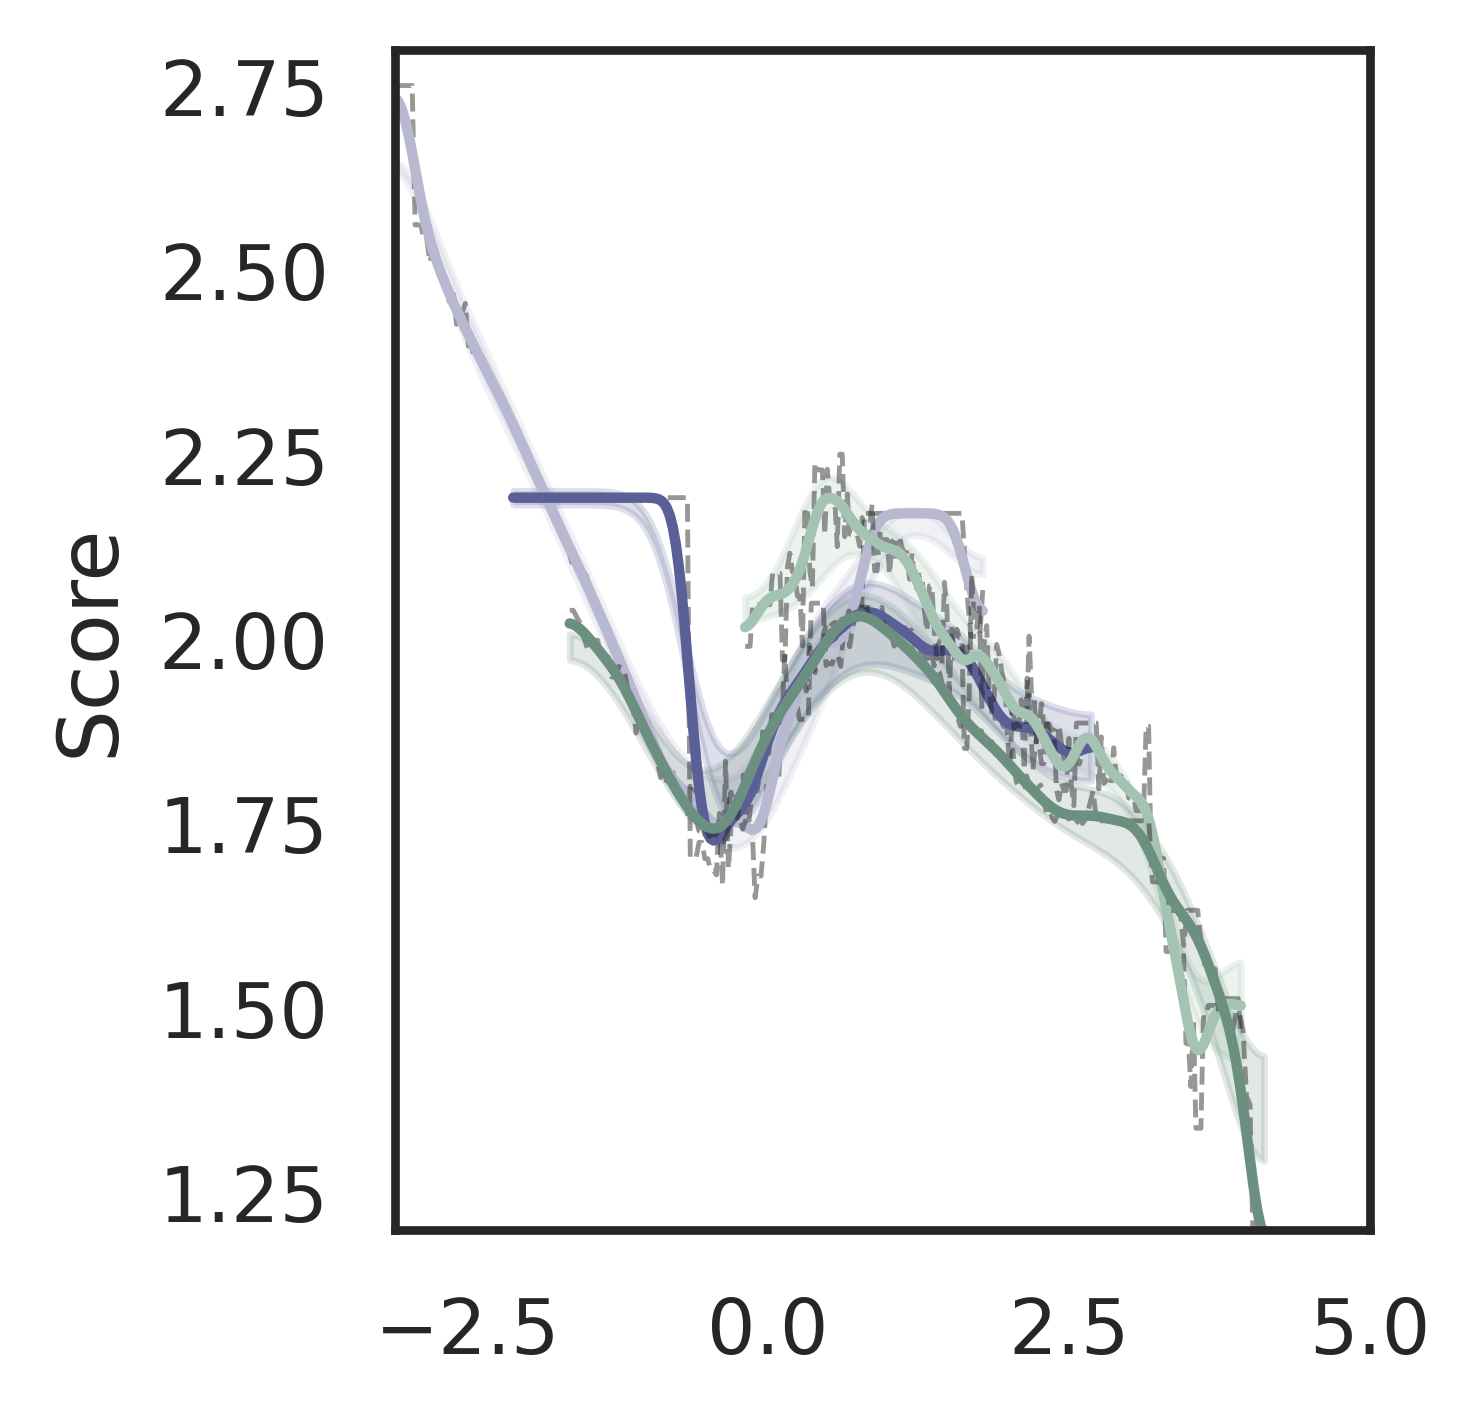

In [46]:
# CD8 exhaustion
cd8_activation = [
'CD3G', 'FASLG', 'ID2', 'LAG3', 'RGS1', 'CCL3 CCL3L1', 'KIAA1671',
       'SH2D2A', 'DUSP2', 'PDCD1', 'CD7', 'NR4A2', 'CD160', 'PTPN22',
       'ABI3', 'PTGER4', 'GZMK', 'GZMA', 'MBNL1', 'VMP1', 'PLAC8', 'RGS3',
       'EFHD2', 'GLRX', 'CXCR6', 'ARL6IP1', 'CCL4', 'ISG15', 'LAX1',
       'CD8A', 'SERPINA3'
]
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(3,3),dpi=500)
gn_filtered = np.intersect1d(cd8_activation,adata_scRNA1[adata_scRNA1.obs.codex_type_label=='CD8 T cells'].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,2.25,2.4,
                    adata_scRNA1[adata_scRNA1.obs.codex_type_label=='CD8 T cells'],colors_='#B8B8D1')

gn_filtered = np.intersect1d(cd8_activation,adata_scRNA2[adata_scRNA2.obs.codex_type_label=='CD8 T cells'].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,2.25,2.4,
                    adata_scRNA2[adata_scRNA2.obs.codex_type_label=='CD8 T cells'],colors_='#5B5F97')

gn_filtered = np.intersect1d(cd8_activation,adata_scRNA3[adata_scRNA3.obs.codex_type_label=='CD8 T cells'].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,2.25,2.4,
                    adata_scRNA3[adata_scRNA3.obs.codex_type_label=='CD8 T cells'],colors_='#A4C3B2')

gn_filtered = np.intersect1d(cd8_activation,adata_scRNA4[adata_scRNA4.obs.codex_type_label=='CD8 T cells'].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,1.2,2.8,
                    adata_scRNA4[adata_scRNA4.obs.codex_type_label=='CD8 T cells'],colors_='#6B9080')
#plt.grid()
plt.tight_layout()
plt.savefig('../figure/fig5g1.pdf',dpi=600)

#plt.legend(['1','2','3','4','5','6','7','8','9'])

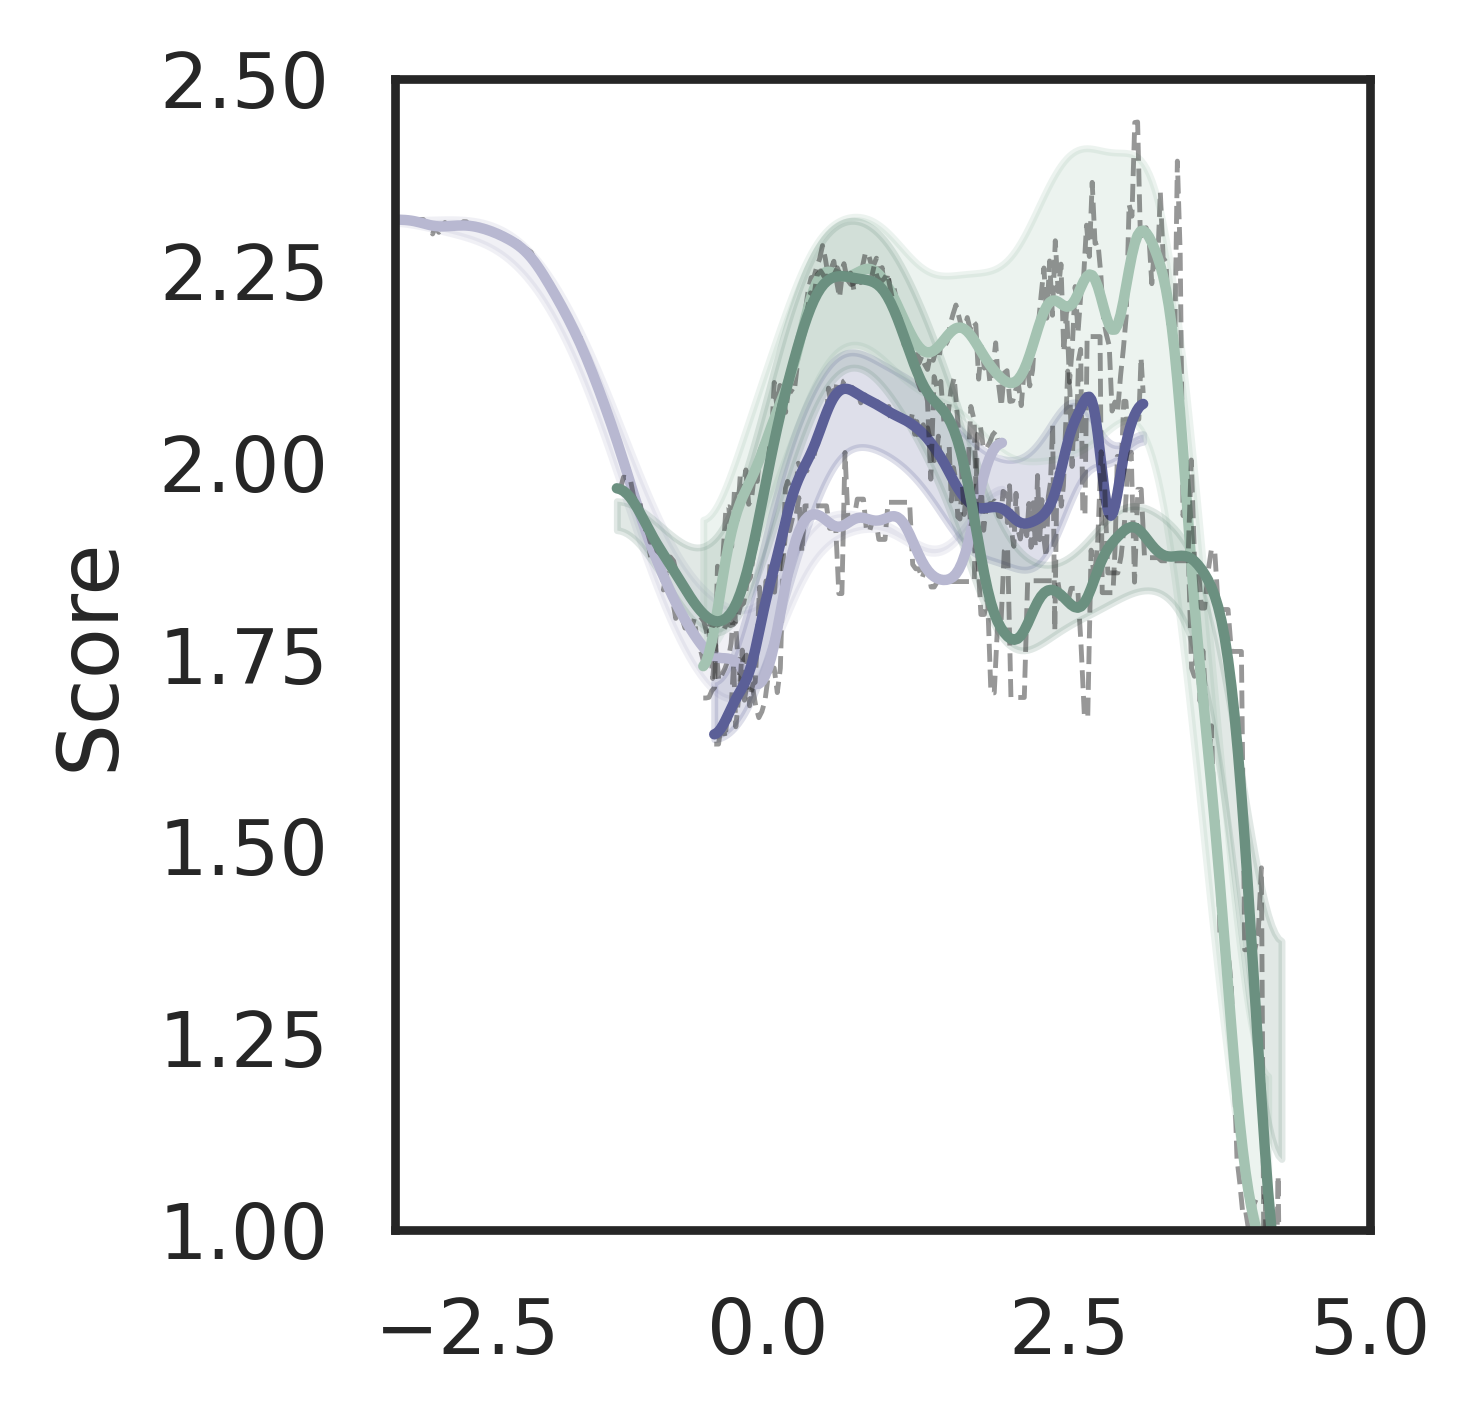

In [44]:
# antiCD4
cd8_activation = [ 'FOXP3', 'PDCD1','CTLA4',
    #'ENTPD1', 'NT5E','IL10','TGFB1','LAG3','ICOS'
       #'CTLA4', 'CARD16', 'TRAC', 'IL2RA', 'CD27', 'DUSP4', 'ICOS', 'CD2',
       #'PMAIP1', 'RGS1', 'AC133644.2', 'TNFRSF9', 'TNFRSF1B', 'SPOCK2',
       #'TBC1D4', 'IL2RG', 'BIRC3', 'S100A4', 'RTKN2', 'CD7', 'ARID5B',
]
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(3,3),dpi=500)
cell_type_ = 'Tumor'
gn_filtered = np.intersect1d(cd8_activation,adata_scRNA1[adata_scRNA1.obs.codex_type_label==cell_type_].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA1[adata_scRNA1.obs.codex_type_label==cell_type_],colors_='#B8B8D1')

plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA2[adata_scRNA2.obs.codex_type_label==cell_type_],colors_='#5B5F97')

plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA3[adata_scRNA3.obs.codex_type_label==cell_type_],colors_='#A4C3B2')

plot_onco_path_traj('NOTCH',gn_filtered,1
                    ,2.5,
                    adata_scRNA4[adata_scRNA4.obs.codex_type_label==cell_type_],colors_='#6B9080')
#plt.grid()
plt.tight_layout()
plt.savefig('../figure/fig5g2.pdf',dpi=600)


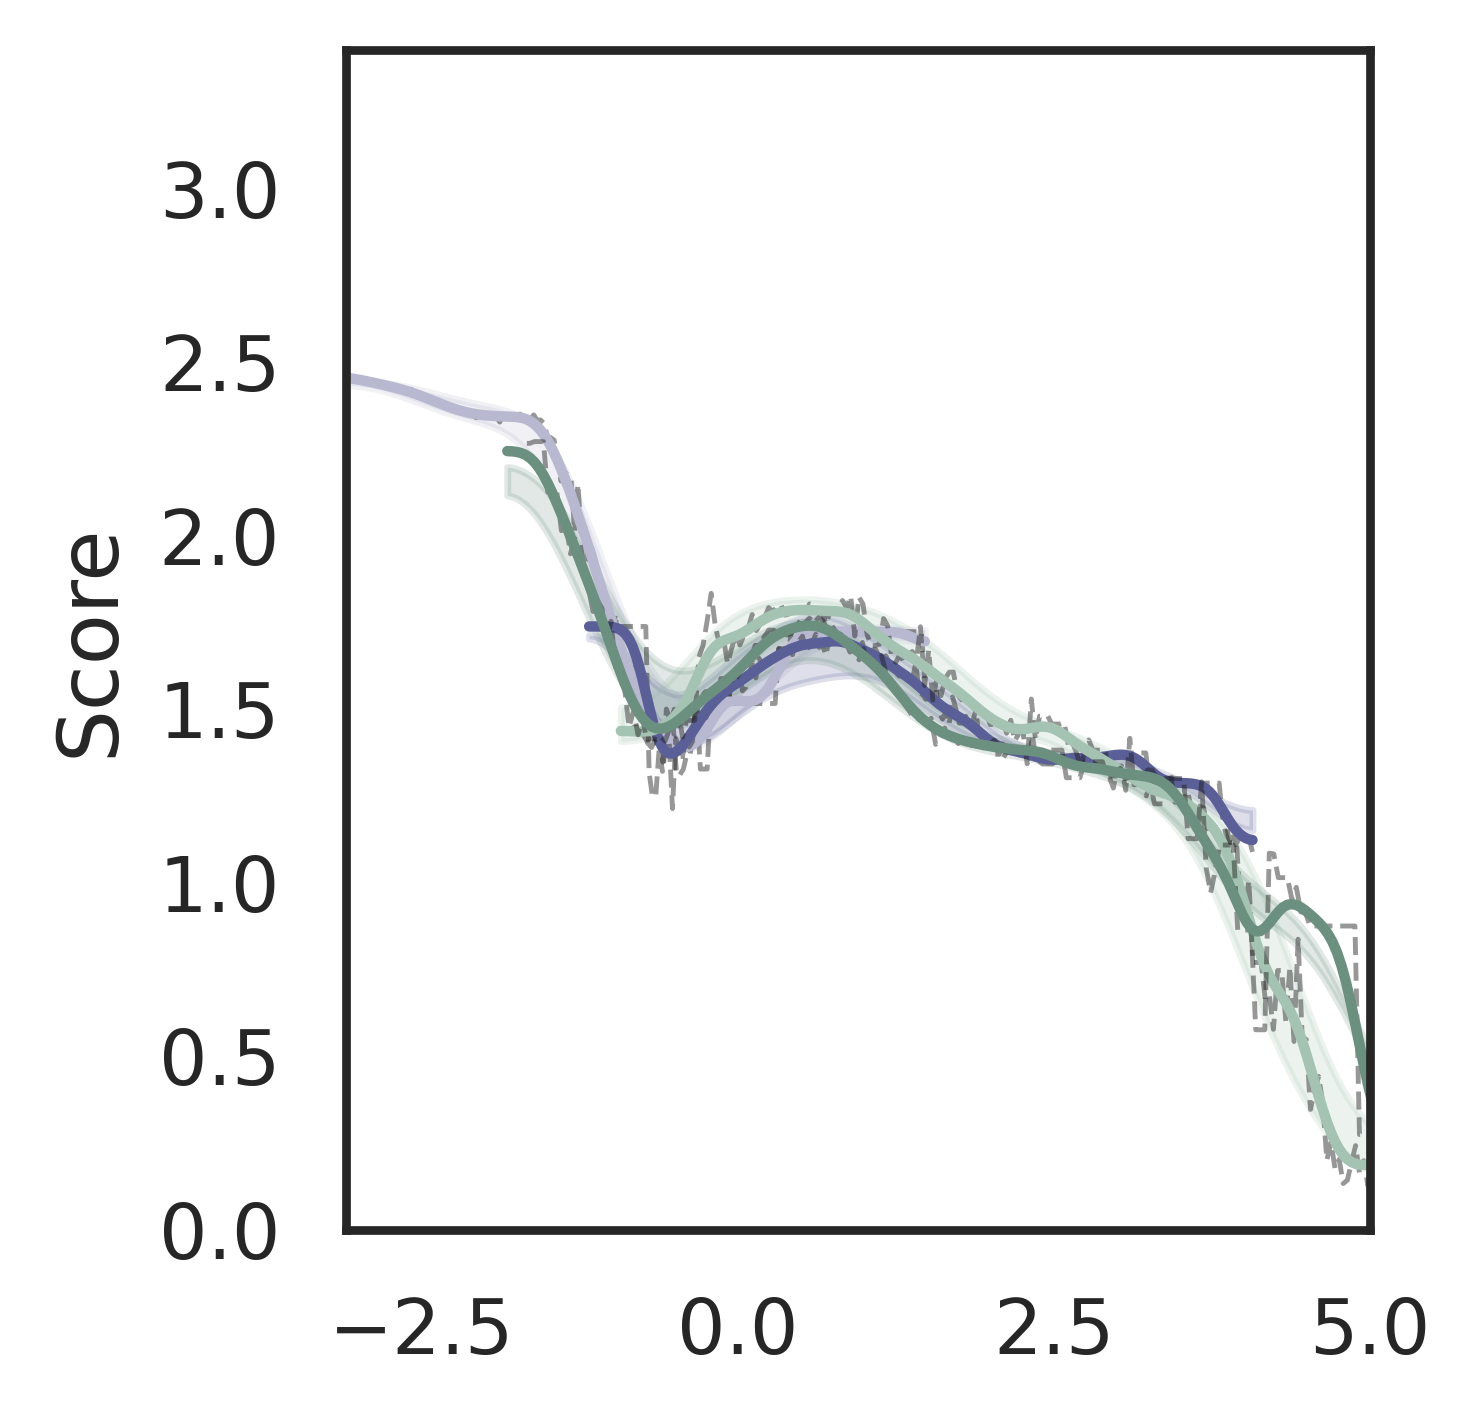

In [47]:
# antiCD4
cd8_activation = [
'COL1A1'
                  # 'FOXP3', 'PDCD1','CTLA4',
    #'ENTPD1', 'NT5E','IL10','TGFB1','LAG3','ICOS'
       #'CTLA4', 'CARD16', 'TRAC', 'IL2RA', 'CD27', 'DUSP4', 'ICOS', 'CD2',
       #'PMAIP1', 'RGS1', 'AC133644.2', 'TNFRSF9', 'TNFRSF1B', 'SPOCK2',
       #'TBC1D4', 'IL2RG', 'BIRC3', 'S100A4', 'RTKN2', 'CD7', 'ARID5B',
]
sns.set(style="white", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(3,3),dpi=500)
cell_type_ = 'Endothelial cells'
gn_filtered = np.intersect1d(cd8_activation,adata_scRNA1[adata_scRNA1.obs.codex_type_label==cell_type_].var_names)
plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA1[adata_scRNA1.obs.codex_type_label==cell_type_],colors_='#B8B8D1')

plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA2[adata_scRNA2.obs.codex_type_label==cell_type_],colors_='#5B5F97')

plot_onco_path_traj('NOTCH',gn_filtered,2.2,2.4,
                    adata_scRNA3[adata_scRNA3.obs.codex_type_label==cell_type_],colors_='#A4C3B2')

plot_onco_path_traj('NOTCH',gn_filtered,0
                    ,3.4,
                    adata_scRNA4[adata_scRNA4.obs.codex_type_label==cell_type_],colors_='#6B9080')
#plt.grid()
plt.tight_layout()
plt.savefig('../figure/fig5g3.pdf',dpi=600)


In [48]:
import decoupler as dc

adata_all_immune_scRNA.obs['qv_bin'] = pd.qcut(adata_all_immune_scRNA.obsm['v_values'].flatten(), q=20)  # Adjust q for the number of bins

progeny = dc.get_progeny(organism='human', top=500)


dc.run_mlm(
    mat=adata_all_immune_scRNA,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

adata_all_immune_scRNA.obsm['progeny_mlm_estimate'] = adata_all_immune_scRNA.obsm['mlm_estimate'].copy()
adata_all_immune_scRNA.obsm['progeny_mlm_pvals'] = adata_all_immune_scRNA.obsm['mlm_pvals'].copy()
adata_all_immune_scRNA

acts = dc.get_acts(adata_all_immune_scRNA, obsm_key='mlm_estimate')


Running mlm on mat with 34578 samples and 1076 targets for 14 sources.


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


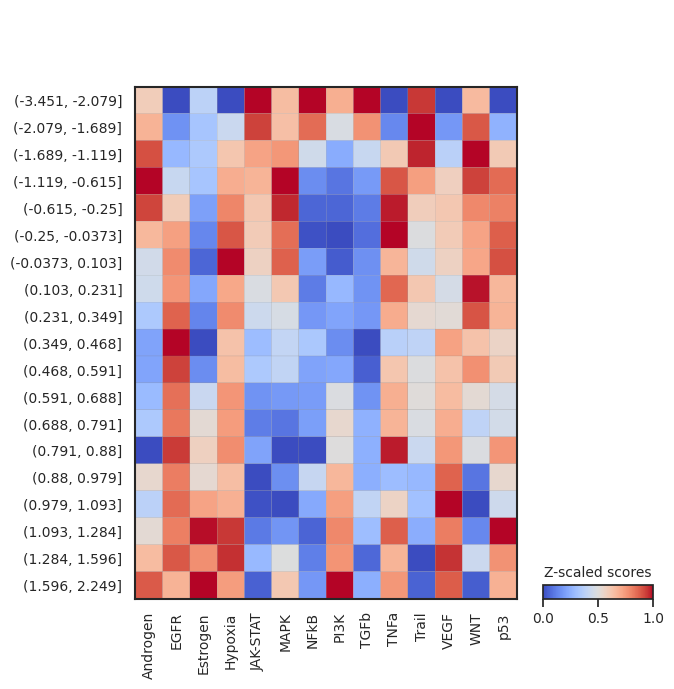

<Figure size 640x480 with 0 Axes>

In [49]:
sc.pl.matrixplot(acts[acts.obs['sample']=='data1'], var_names=acts.var_names, groupby='qv_bin', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='coolwarm',show=False)
plt.savefig('../figure/fig5h1.pdf',dpi=600)

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


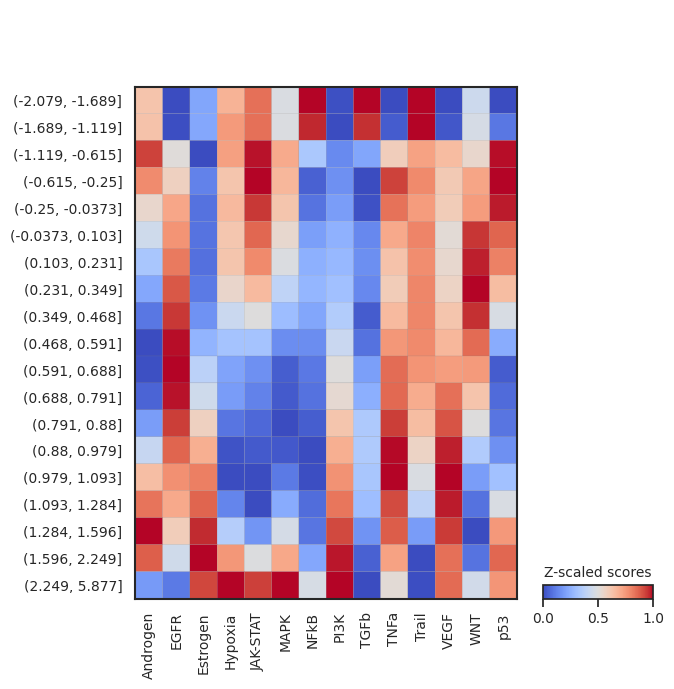

In [50]:
sc.pl.matrixplot(acts[acts.obs['sample']=='data2'], var_names=acts.var_names, groupby='qv_bin', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='coolwarm',show=False)
plt.savefig('../figure/fig5h2.pdf',dpi=600)

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


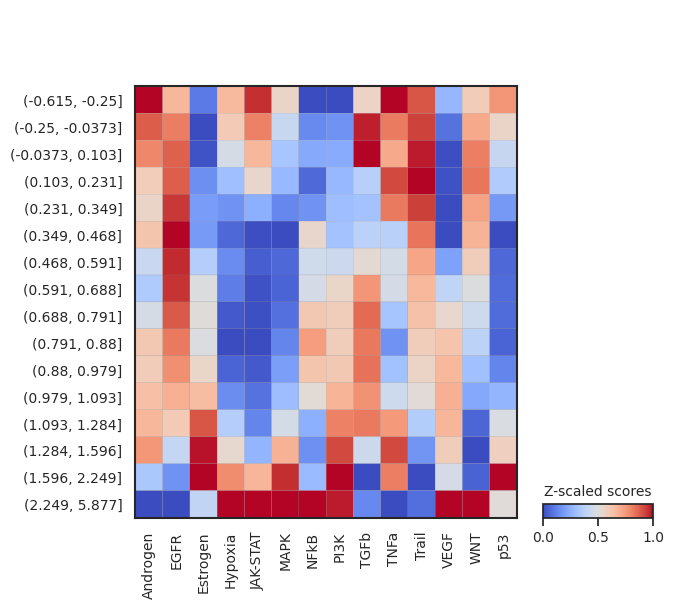

In [51]:
sc.pl.matrixplot(acts[acts.obs['sample']=='data3'], var_names=acts.var_names, groupby='qv_bin', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='coolwarm',show=False)
plt.savefig('../figure/fig5h3.pdf',dpi=600)

/hpc/mydata/siyu.he/anaconda/2023.03/x86_64/envs/scvi_v1_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


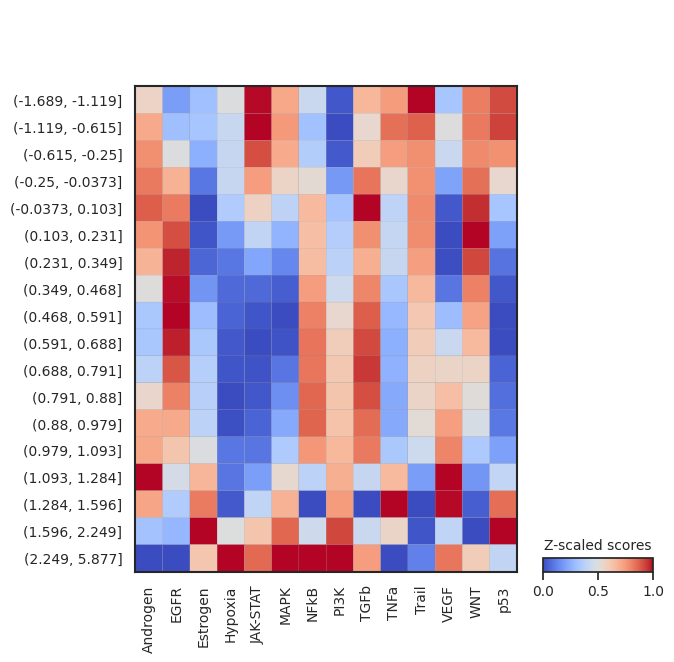

In [52]:
sc.pl.matrixplot(acts[acts.obs['sample']=='data4'], var_names=acts.var_names, groupby='qv_bin', dendrogram=False, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='coolwarm',show=False)
plt.savefig('../figure/fig5h4.pdf',dpi=600)